In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor

Make the plots pretty and uniform in style.

In [2]:
# set Matplotlib defaults
plt.style.use('seaborn-whitegrid')
plt.rc('figure', autolayout=True, figsize=(11, 5))
plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

/tmp/ipykernel_15700/698099135.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [3]:
path = './store-sales-forecasting-data/train.csv'
dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64'
}

df = pd.read_csv(
    path, 
    dtype=dtype, 
    index_col=['id'], 
    parse_dates=['date'], 
    infer_datetime_format=True
)
df.head()

date store_nbr      family  sales  onpromotion
id                                                     
0  2013-01-01         1  AUTOMOTIVE    0.0            0
1  2013-01-01         1   BABY CARE    0.0            0
2  2013-01-01         1      BEAUTY    0.0            0
3  2013-01-01         1   BEVERAGES    0.0            0
4  2013-01-01         1       BOOKS    0.0            0

In [4]:
df = df.set_index('date').to_period('D')

In [5]:
df = df.set_index(['store_nbr', 'family'], append=True)

In [6]:
average_sales = df.groupby('date').mean()['sales']
average_sales.head()

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911163
2013-01-05    267.873260
Freq: D, Name: sales, dtype: float32

In [7]:
df2 = average_sales.to_frame()
df2.head()

sales
date                  
2013-01-01    1.409438
2013-01-02  278.390808
2013-01-03  202.840195
2013-01-04  198.911163
2013-01-05  267.873260

In [8]:
time = np.arange(len(df2.index))

df2['time'] = time

X = df2.loc[:, ['time']]
y = df2.loc[:, 'sales']

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

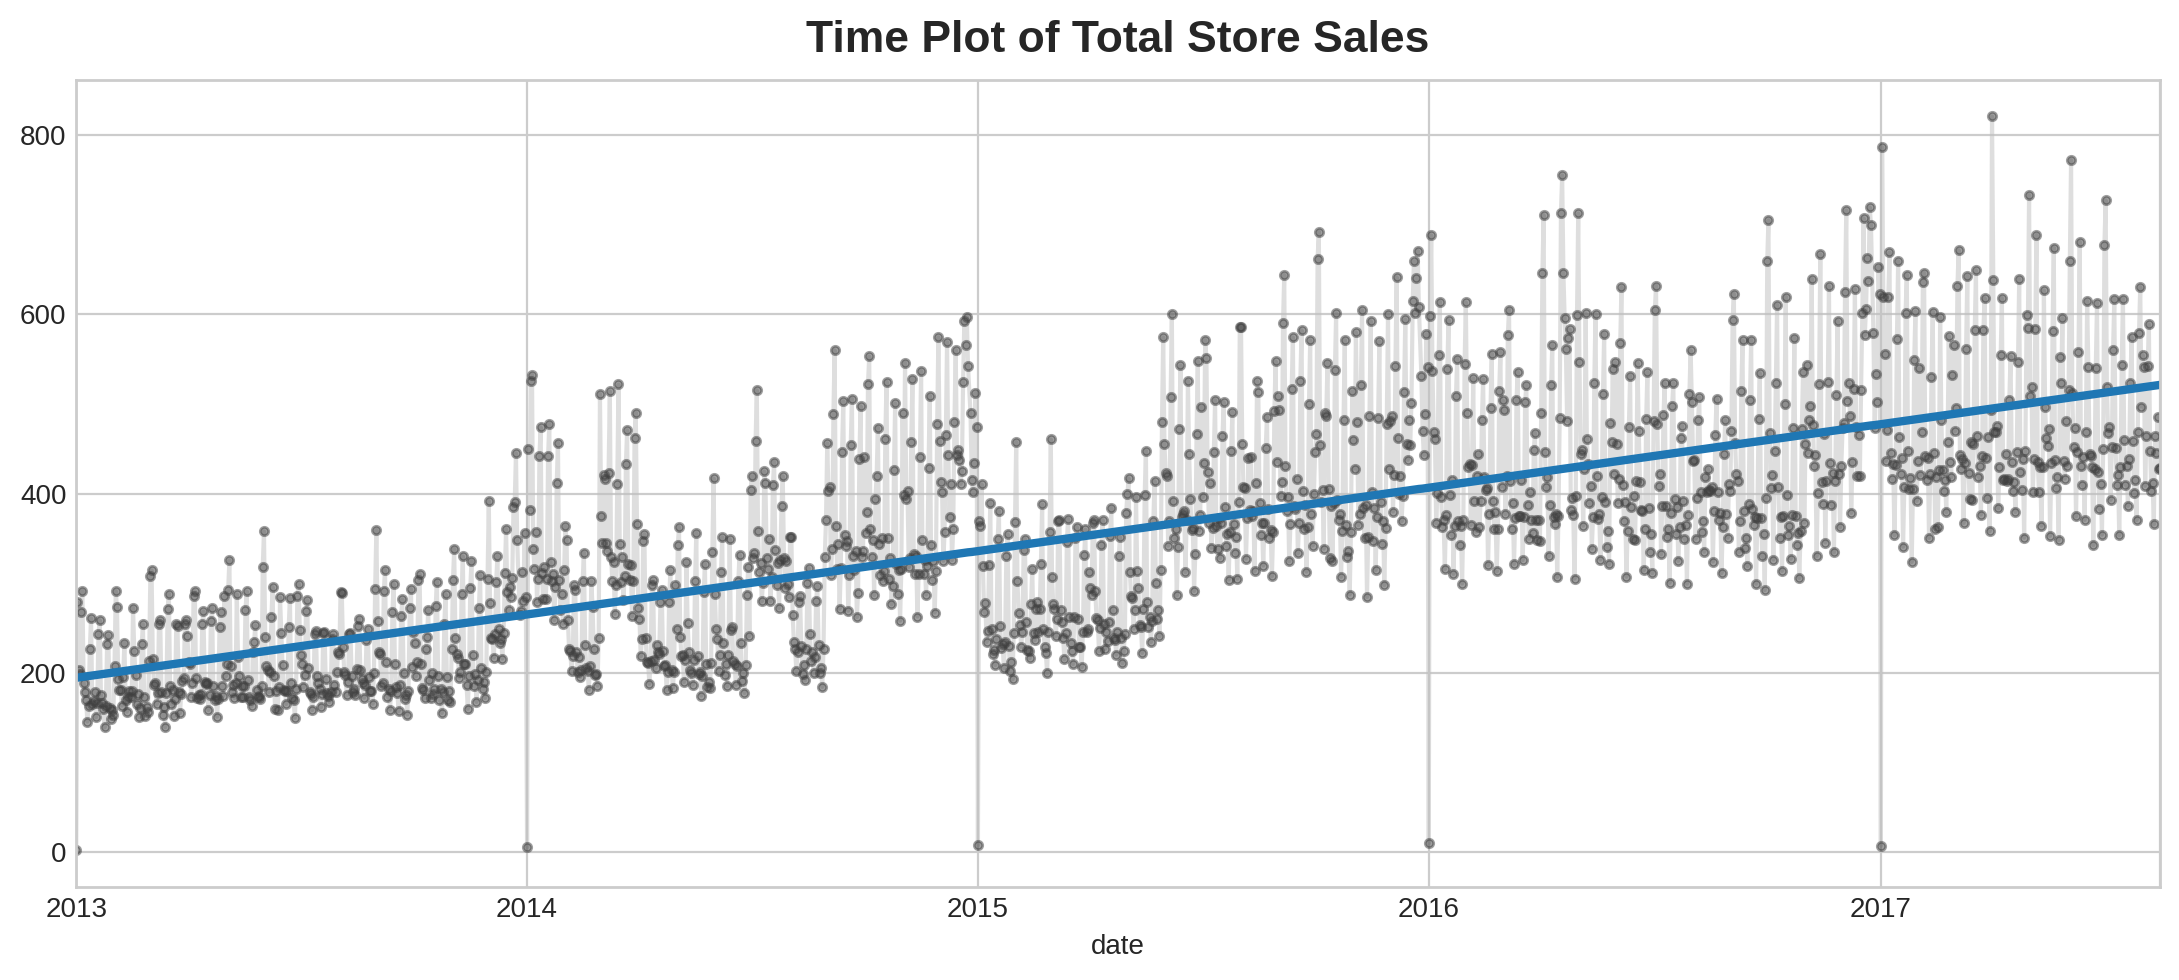

In [9]:
ax = y.plot(**plot_params, alpha=0.5)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Total Store Sales');

In [10]:
lag_1 = df2['sales'].shift(1)

df2['lag_1'] = lag_1

X = df2.loc[:, ['lag_1']].dropna()
y = df2.loc[:, 'sales']
y, X = y.align(X, join='inner')

model= LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

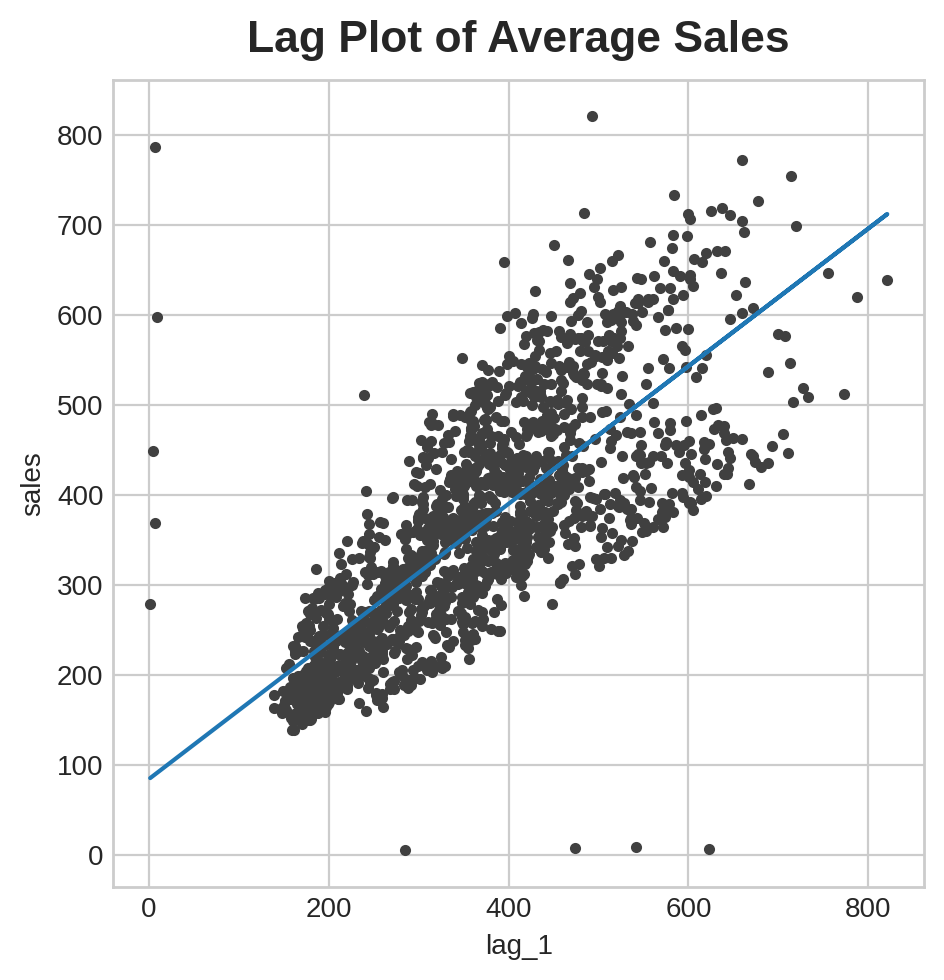

In [11]:
fig, ax = plt.subplots()

ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales');

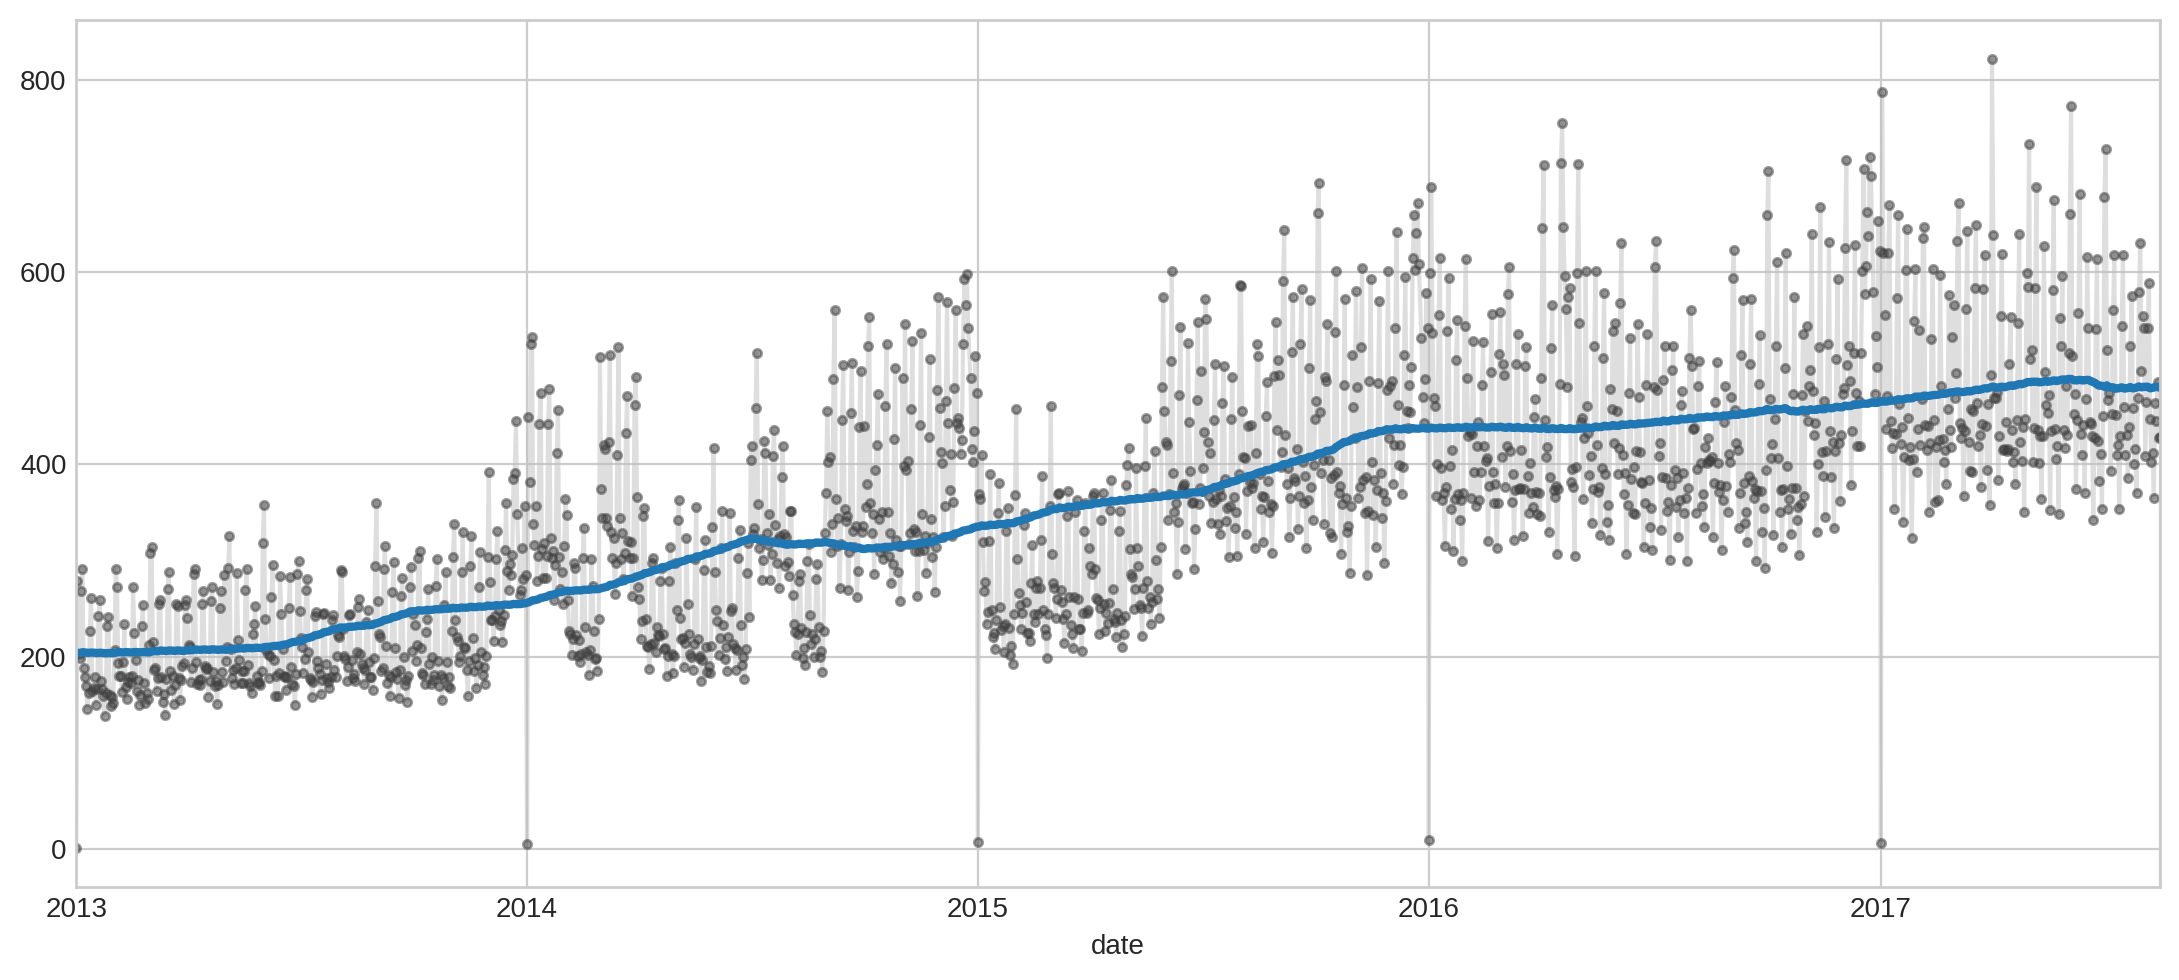

In [12]:

trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = average_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

In [13]:
y = average_sales.copy()

dp = DeterministicProcess(index=y.index, order=3)
X = dp.in_sample()
X_fore = dp.out_of_sample(steps=90)

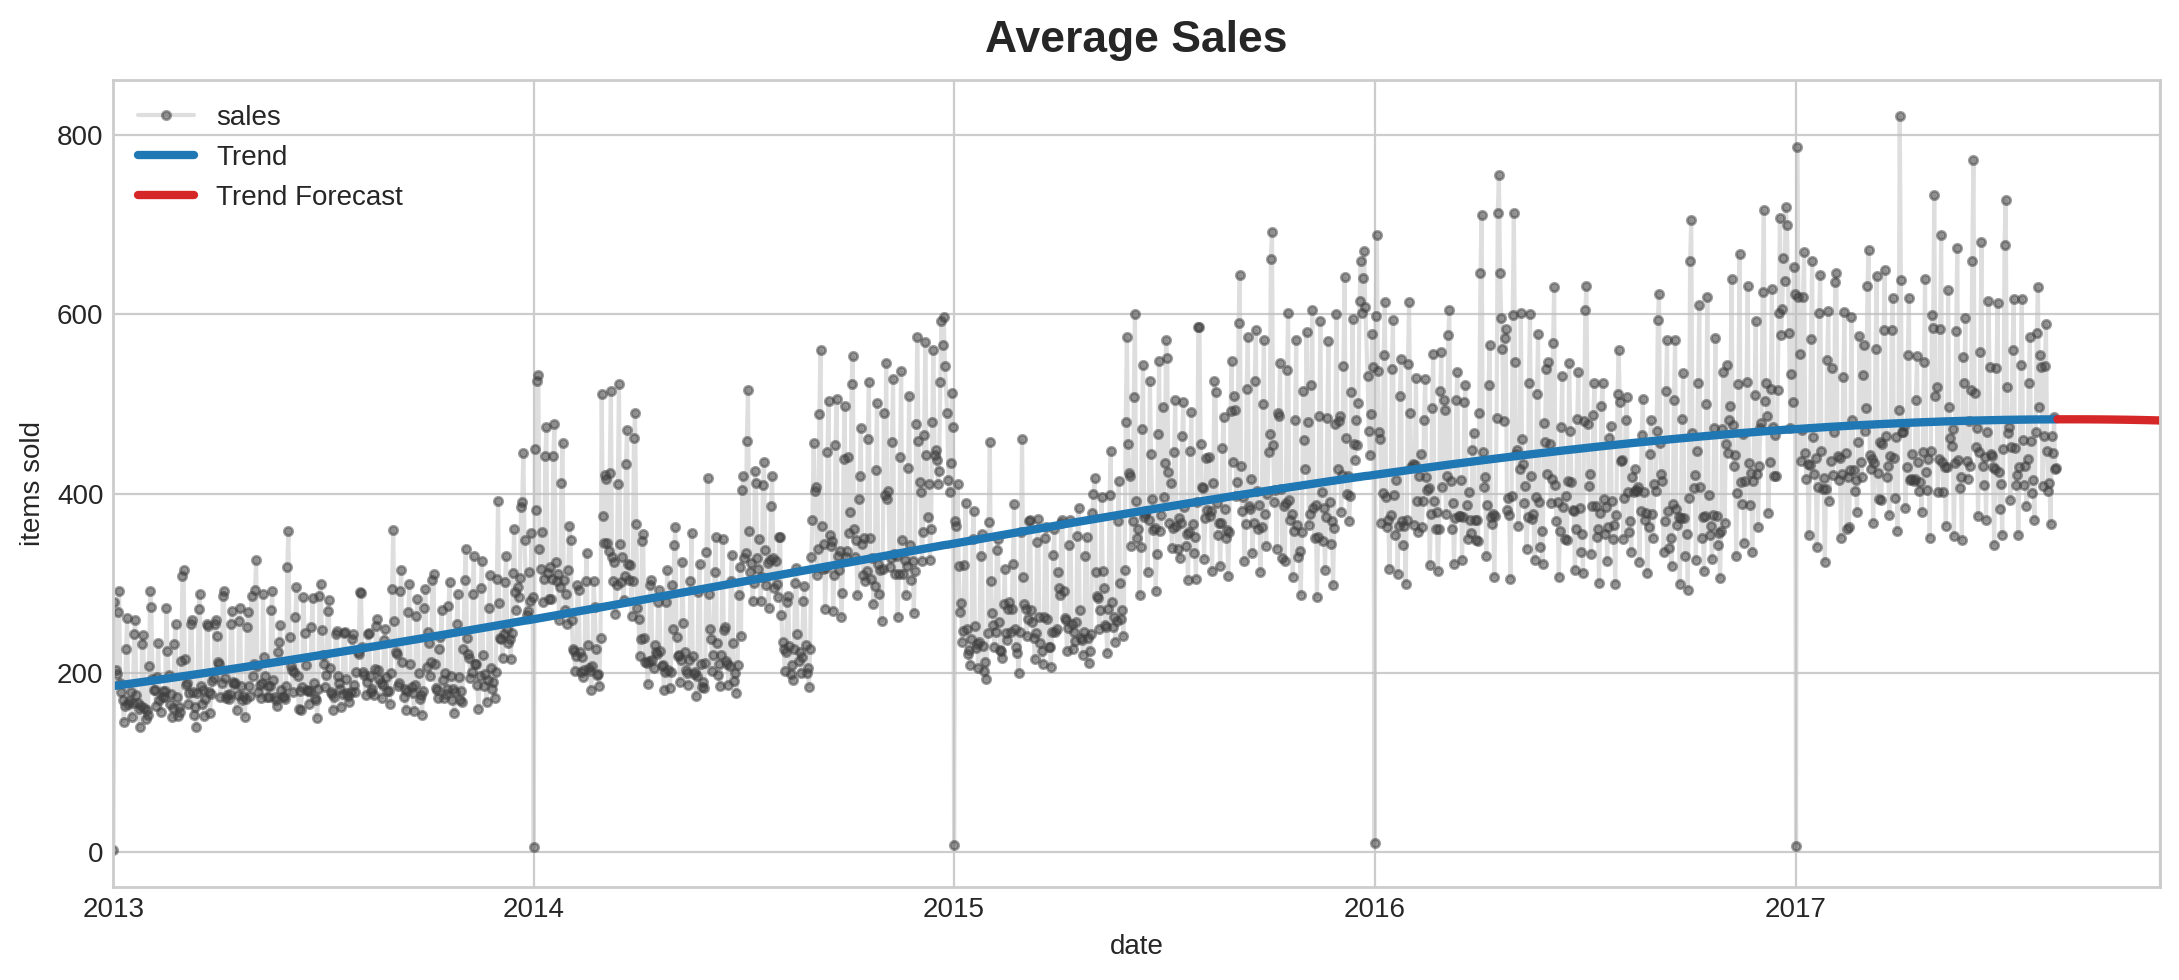

In [14]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title='Average Sales', ylabel='items sold')
ax = y_pred.plot(ax=ax, linewidth=3, label='Trend', color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label='Trend Forecast', color='C3')
ax.legend();

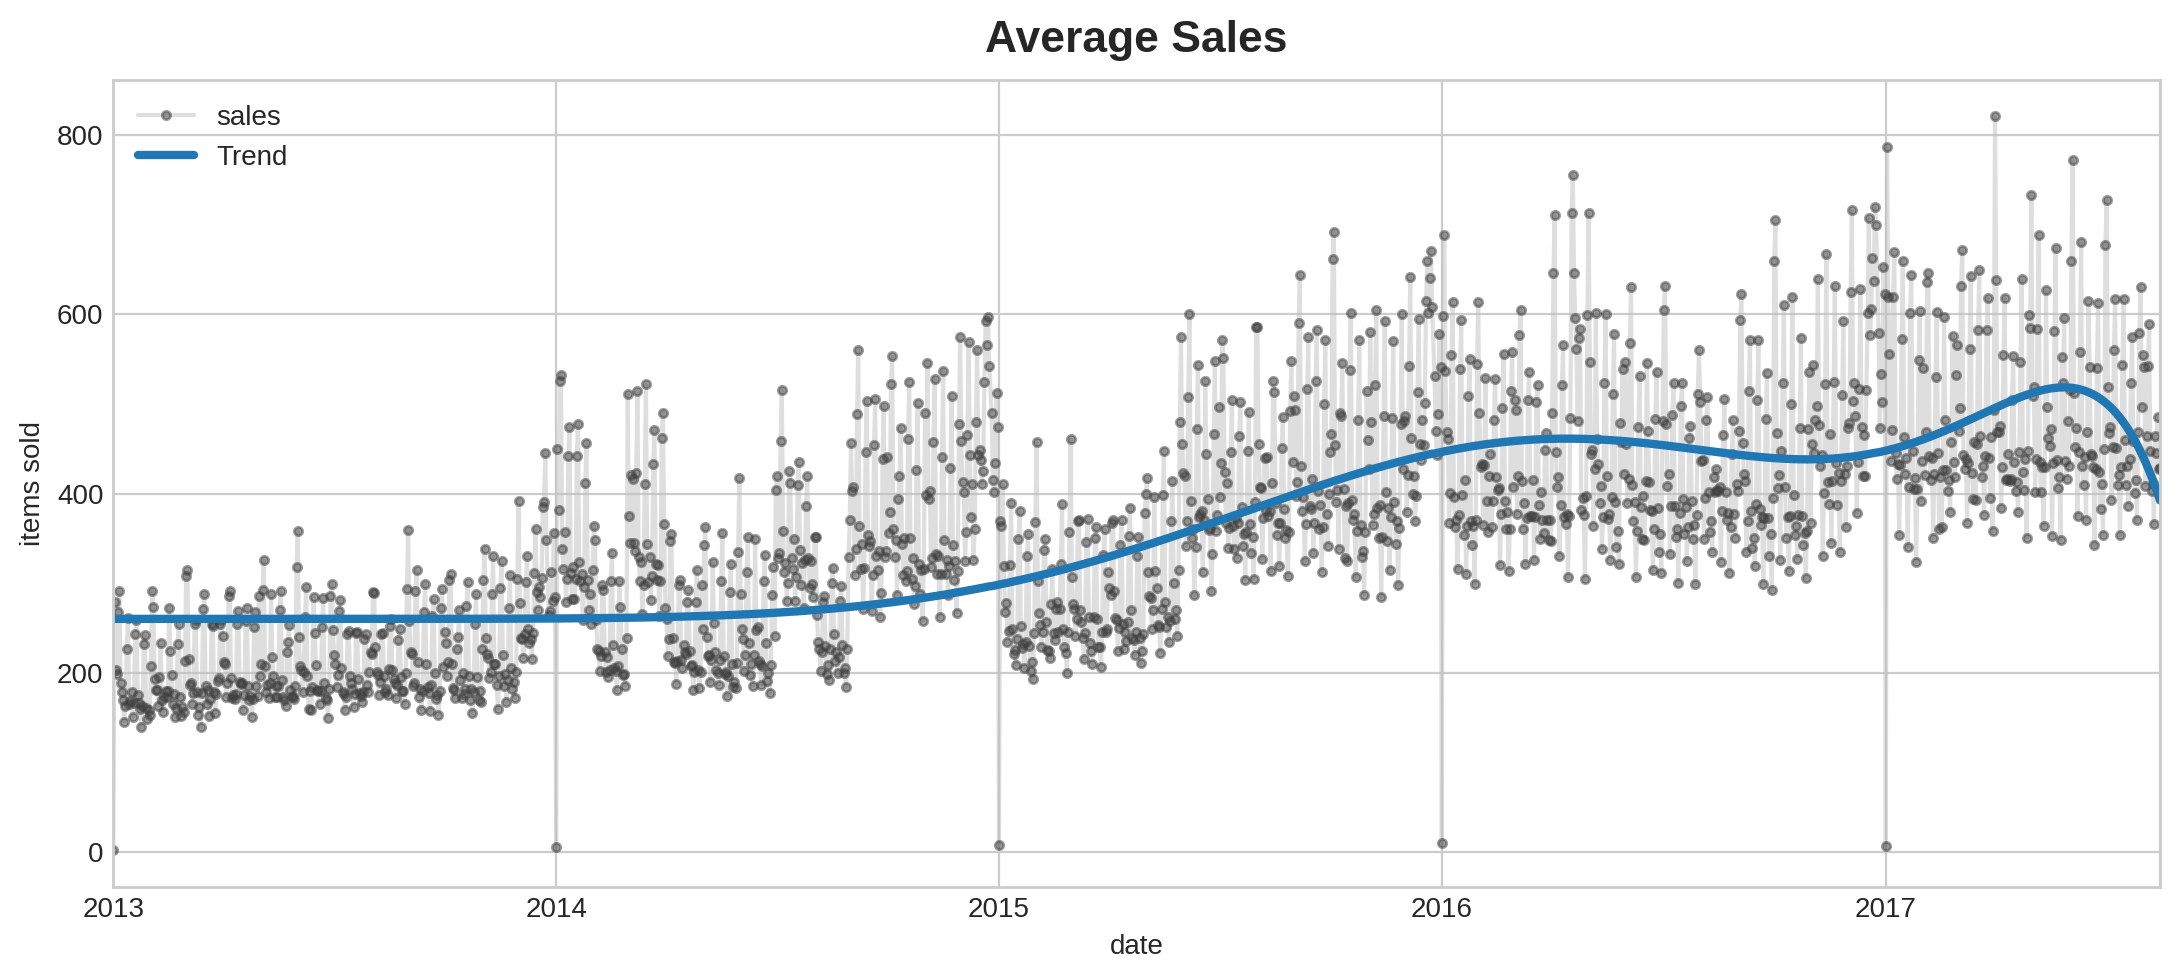

In [15]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(index=y.index, order=11)
X = dp.in_sample()

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(**plot_params, alpha=0.5, title='Average Sales', ylabel='items sold')
ax = y_pred.plot(ax=ax, linewidth=3, label='Trend', color='C0')
ax.legend();

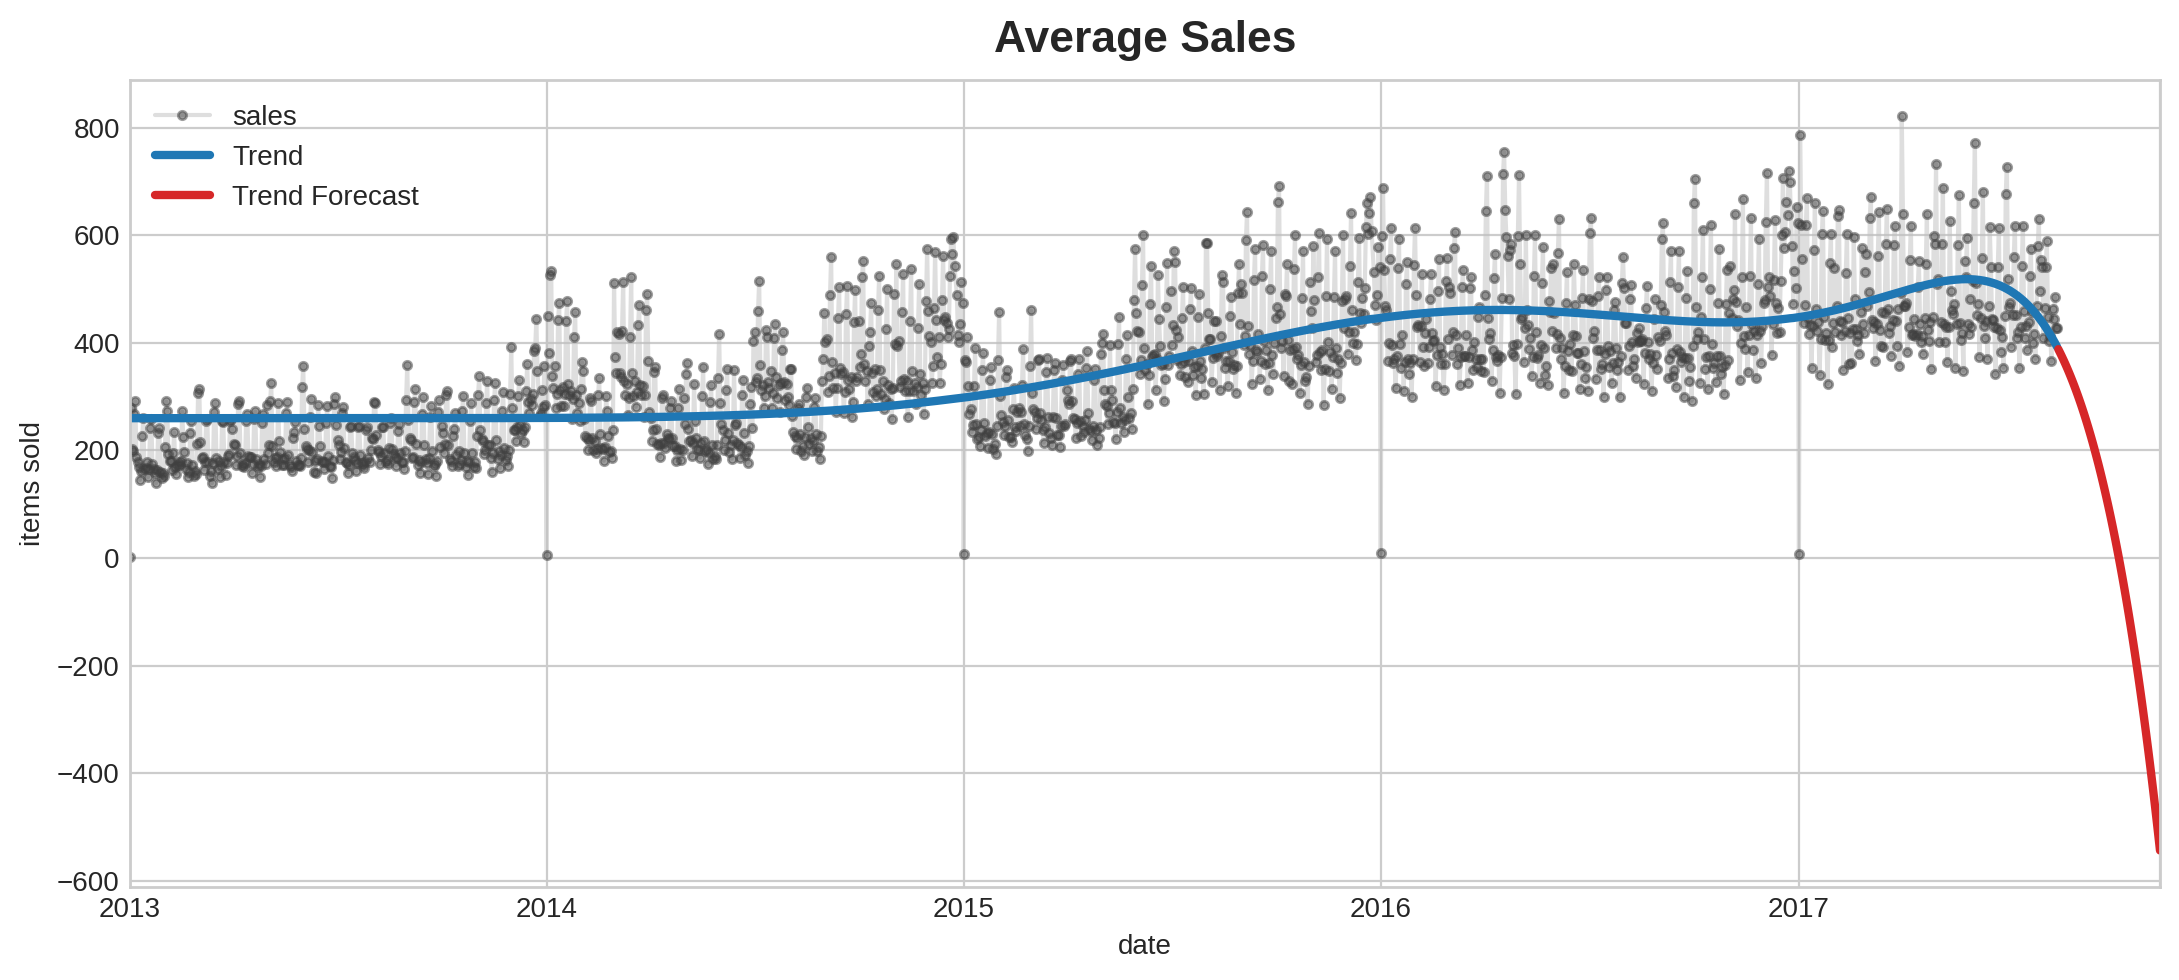

In [16]:
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title='Average Sales', ylabel='items sold')
ax = y_pred.plot(ax=ax, linewidth=3, label='Trend', color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label='Trend Forecast', color='C3')
ax.legend();

In [17]:
path2 = './store-sales-forecasting-data/holidays_events.csv'
holidays_events = pd.read_csv(
    path2,
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')
holidays_events.head()

type    locale locale_name                    description  \
date                                                                       
2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

            transferred  
date                     
2012-03-02        False  
2012-04-01        False  
2012-04-12        False  
2012-04-14        False  
2012-04-21        False

In [18]:
store_sales = pd.read_csv(
    path,
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales2 = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)
average_sales2.head()

date
2017-01-01      6.780303
2017-01-02    786.928406
2017-01-03    619.740234
2017-01-04    555.607971
2017-01-05    436.375397
Freq: D, Name: sales, dtype: float32

In [19]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette('husl', n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f'Seasonal Plot ({period}/{freq})')
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords='offset points',
            size=14,
            va='center',
        )
    return ax

In [20]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta('1Y') / pd.Timedelta('1D')
    frequencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window='boxcar',
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(frequencies, spectrum, color='purple')
    ax.set_xscale('log')
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            'Annual (1)',
            'Semiannual (2)',
            'Quarterly (4)',
            'Bimonthly (6)',
            'Monthly (12)',
            'Biweekly (26)',
            'Weekly (52)',
            'Semiweekly (104)',
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    ax.set_ylabel('Variance')
    ax.set_title('Periodogram')
    return ax

/tmp/ipykernel_15700/917650288.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(


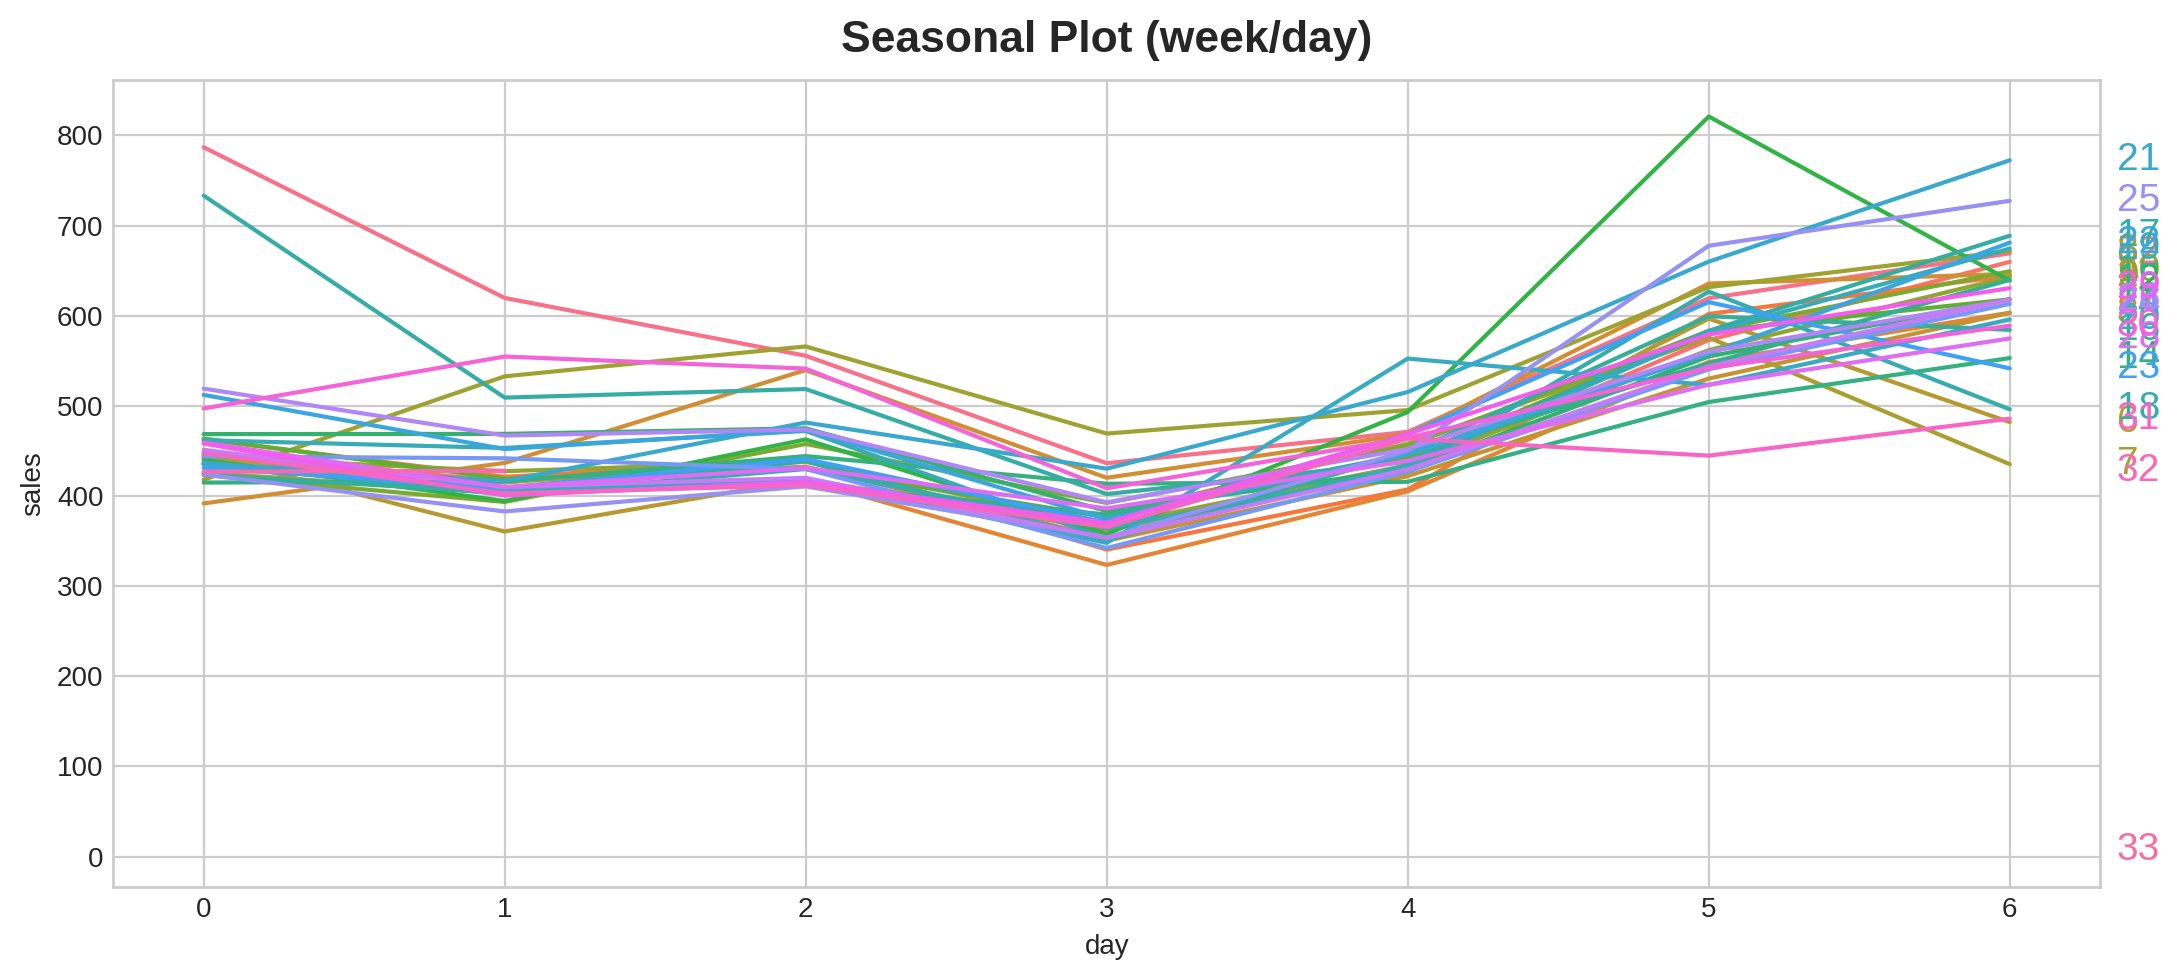

In [21]:
X = average_sales2.to_frame()
X['week'] = X.index.week
X['day'] = X.index.dayofweek
seasonal_plot(X, y='sales', period='week', freq='day');

/tmp/ipykernel_15700/1860798302.py:3: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta('1Y') / pd.Timedelta('1D')


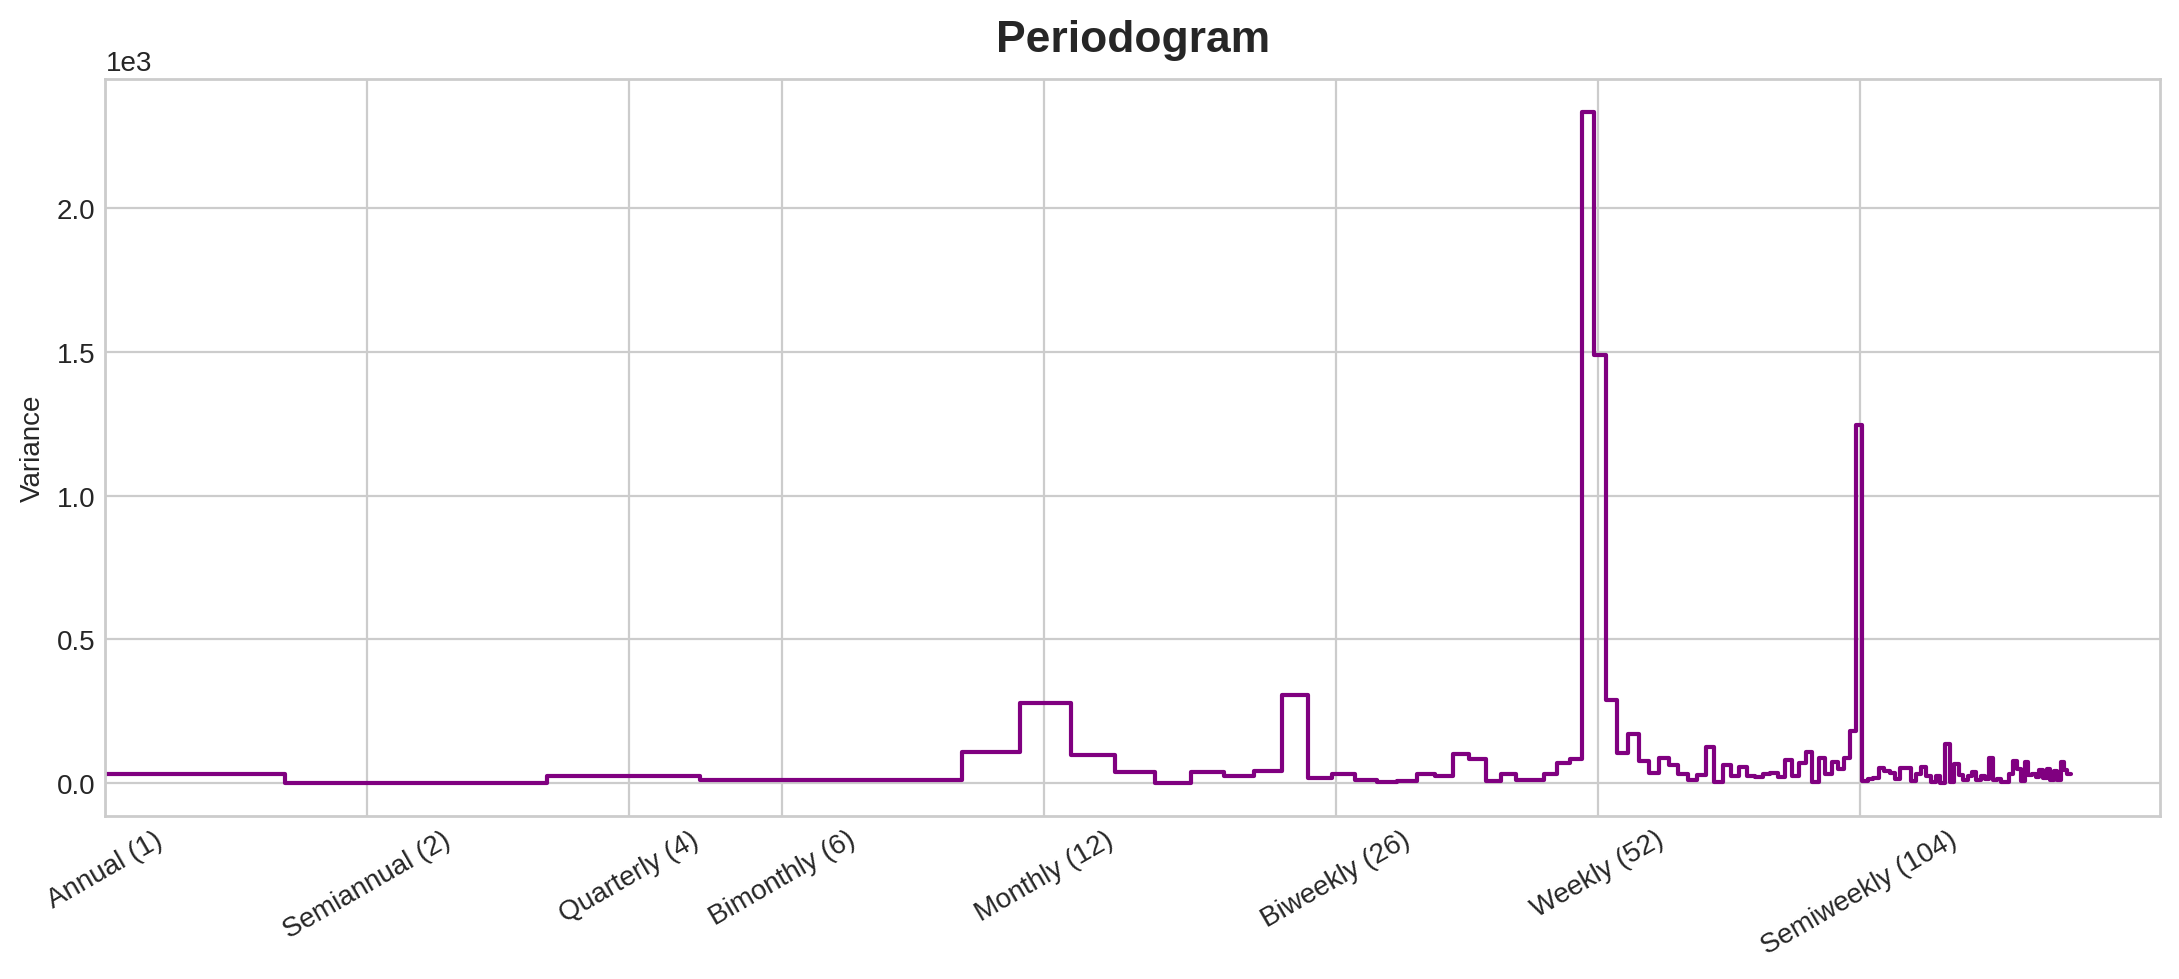

In [22]:
plot_periodogram(average_sales2);

Both the seasonal plot and the periodogram suggest a strong weekly seasonality. From the periodogram, it appears there may be some monthly and biweekly components as well. In fact, the notes to the Store Sales dataset say wages in the public sector are paid out biweekly, on the 15th and last day of the month -- a possible origin for these seasons.

In [23]:
y = average_sales2.copy()

# YOUR CODE HERE
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()

Now run this cell to fit the seasonal model.

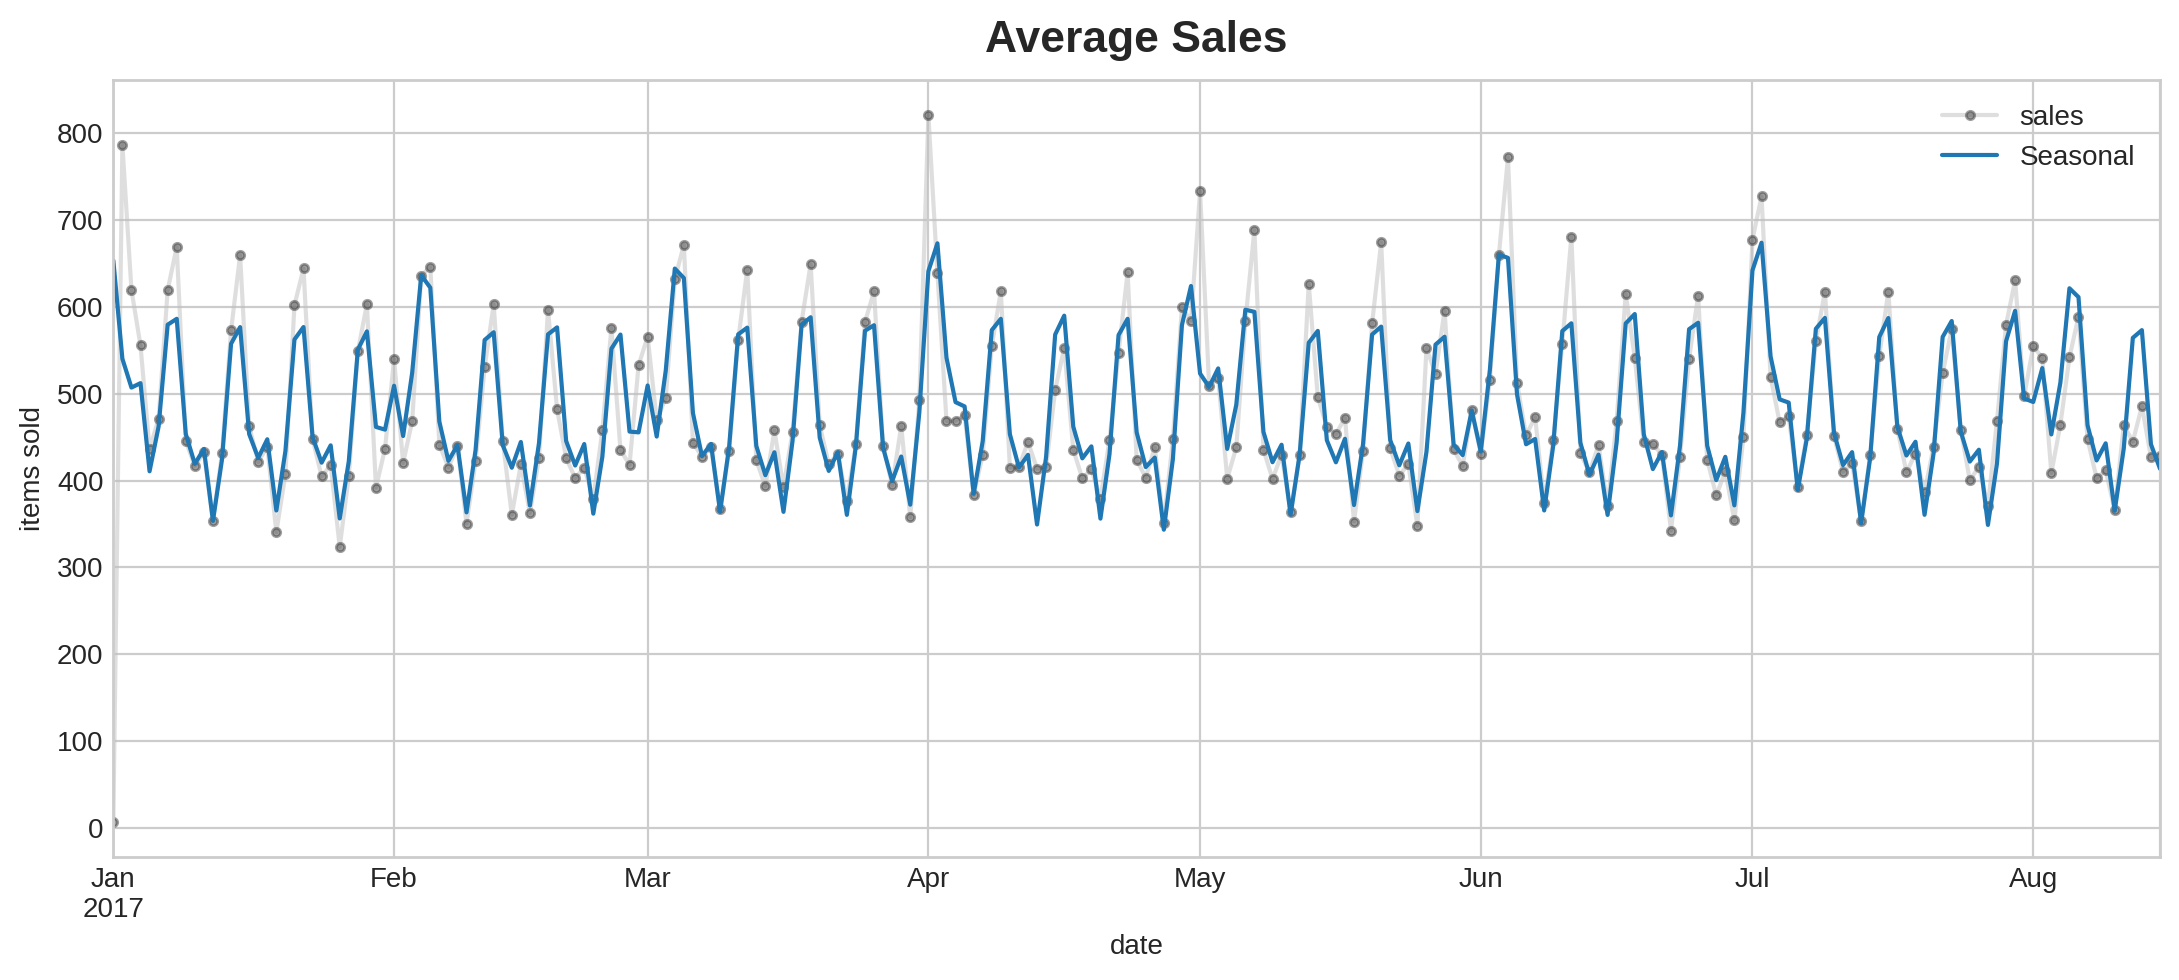

In [24]:
model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

ax = y.plot(**plot_params, alpha=0.5, title='Average Sales', ylabel='items sold')
ax = y_pred.plot(ax=ax, label='Seasonal')
ax.legend();

Now we remove the trend/seasons from the data series, or we detrending or desasonalizing the series. Compare the periodogram.

/tmp/ipykernel_15700/1860798302.py:3: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta('1Y') / pd.Timedelta('1D')


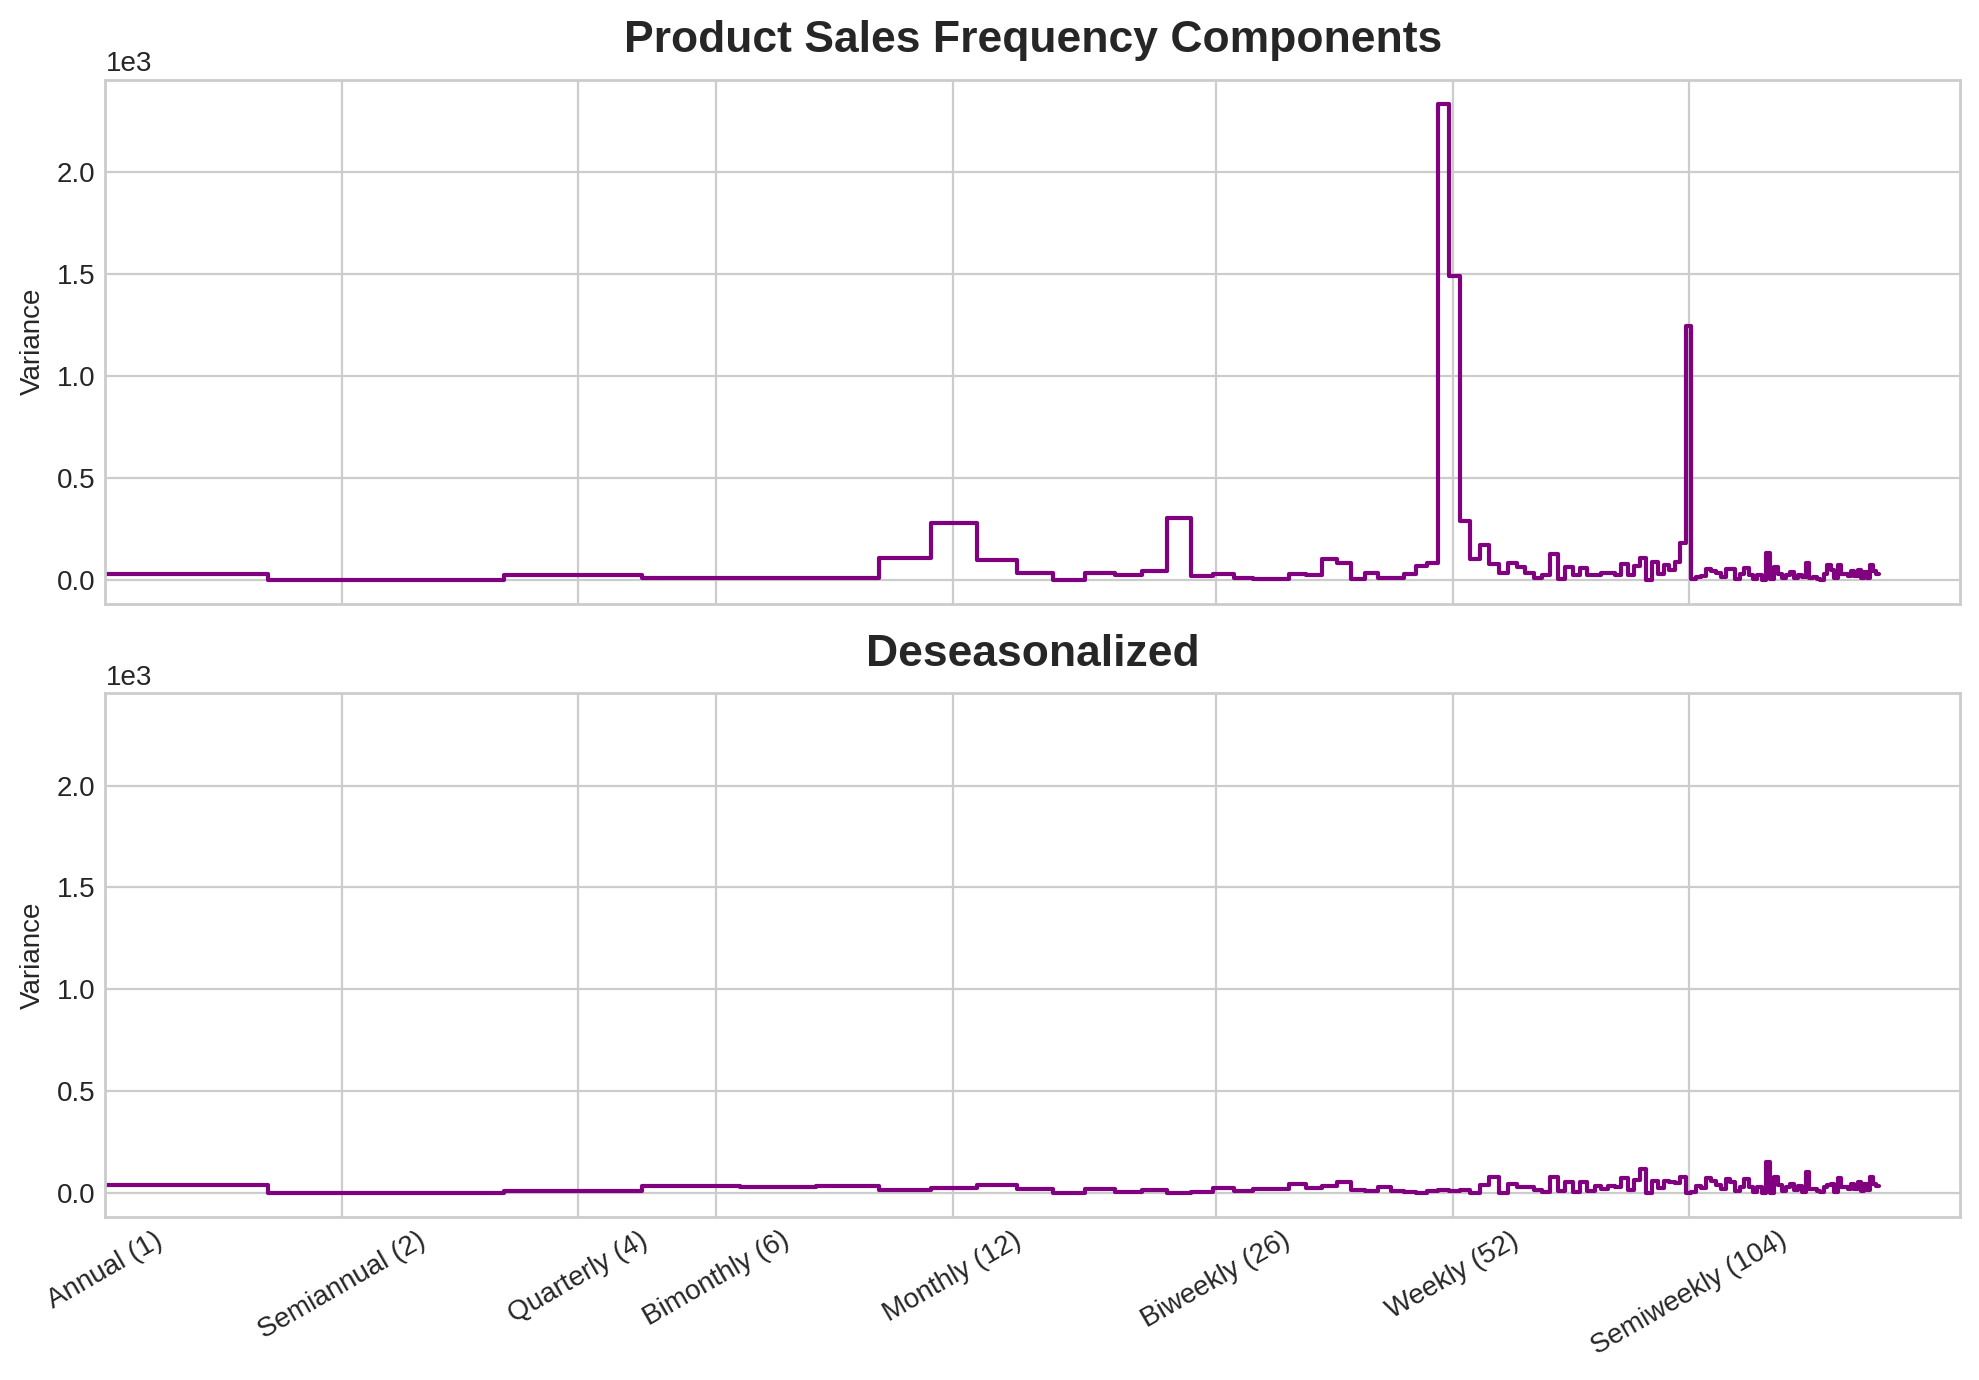

In [25]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title('Product Sales Frequency Components')
ax2 = plot_periodogram(y_deseason, ax=ax2)
ax2.set_title('Deseasonalized');

The periodogram for the deseasonalized series lacks any large values. By comparing it to the periodogram for the original series, we can see that our model was able to capture the seasonal variation in Average Sales.

We can also take into consideration the holidays by incorporating holidays dataset.

In [26]:
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017': '2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

display(holidays)

description
date                                              
2017-01-01                      Primer dia del ano
2017-01-02             Traslado Primer dia del ano
2017-02-27                                Carnaval
2017-02-28                                Carnaval
2017-04-01           Provincializacion de Cotopaxi
2017-04-14                           Viernes Santo
2017-05-01                         Dia del Trabajo
2017-05-13                       Dia de la Madre-1
2017-05-14                         Dia de la Madre
2017-05-24                    Batalla de Pichincha
2017-05-26           Traslado Batalla de Pichincha
2017-06-25           Provincializacion de Imbabura
2017-08-10           Primer Grito de Independencia
2017-08-11  Traslado Primer Grito de Independencia

Place these dates on the deseasonalized average sales plot to view the effect.

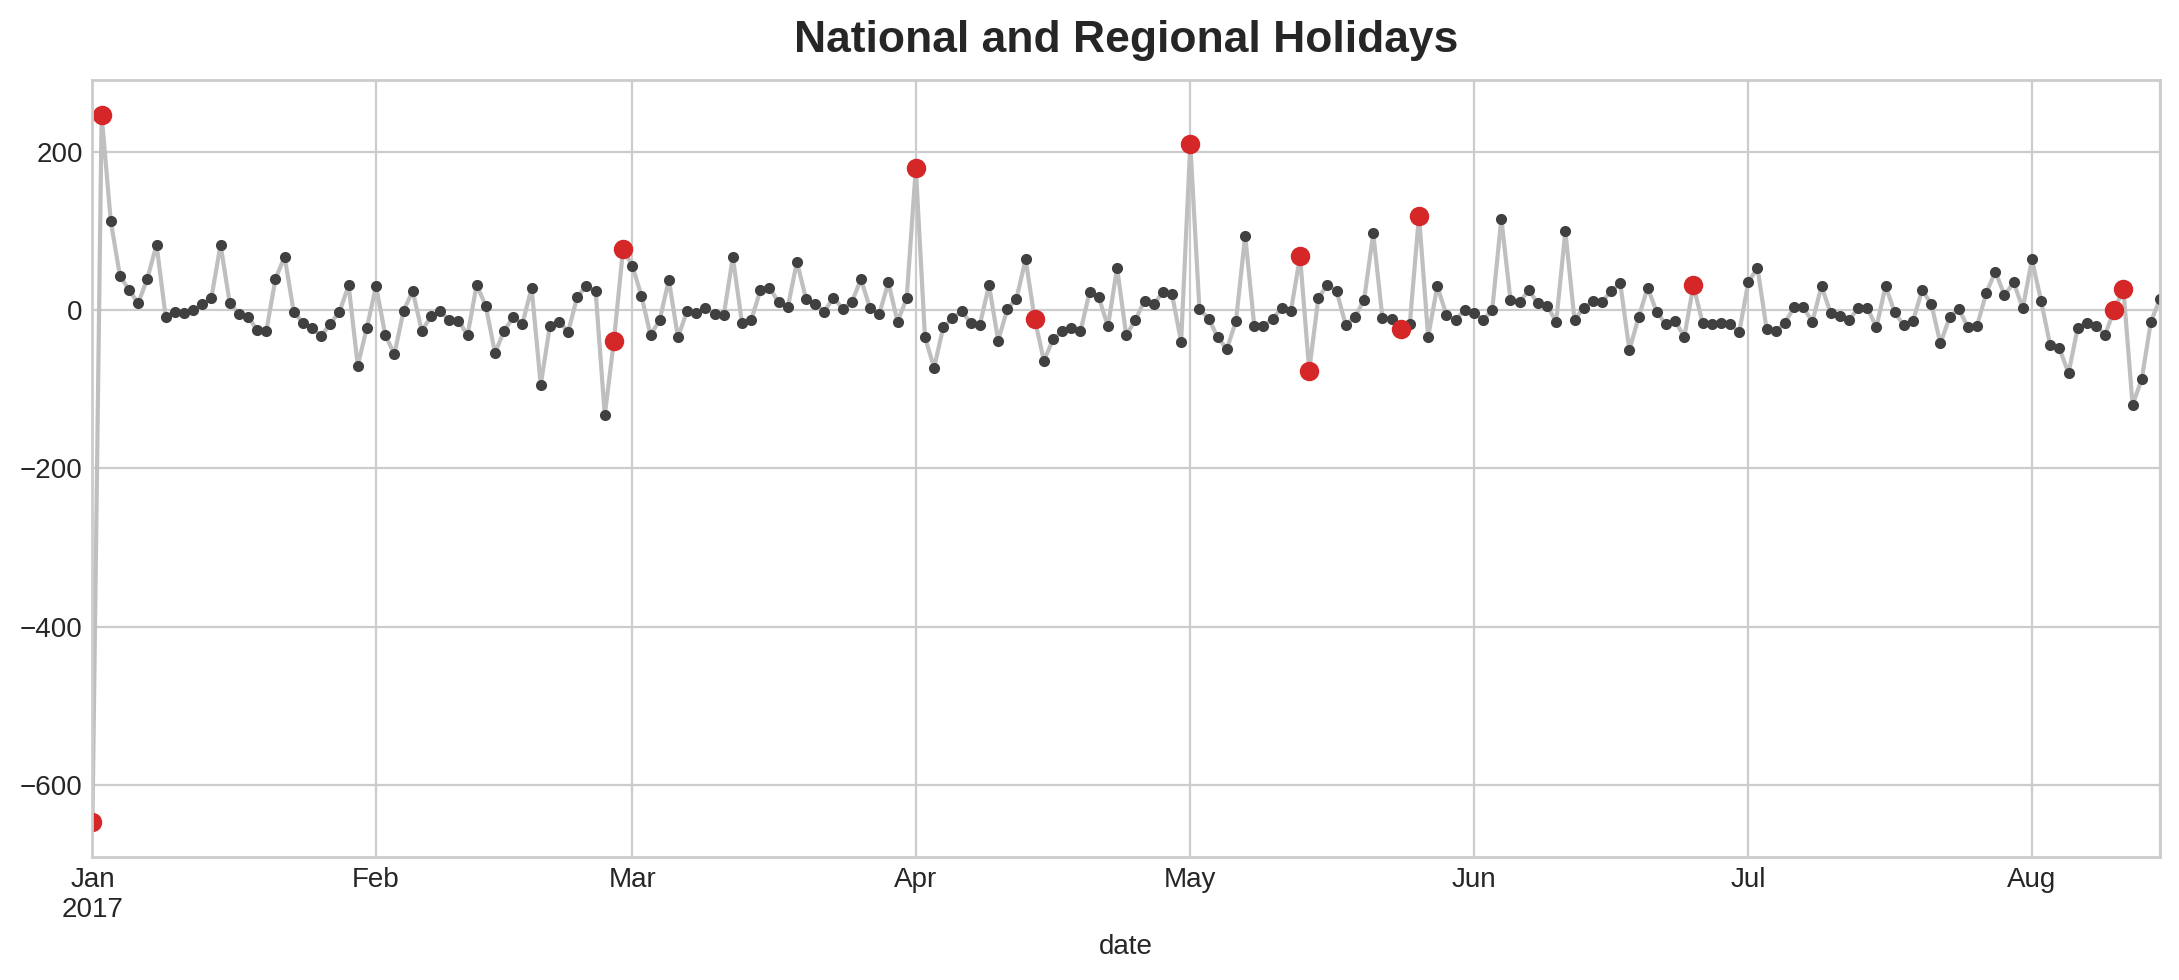

In [27]:
ax = y_deseason.plot(**plot_params)
plt.plot_date(holidays.index, y_deseason[holidays.index], color='C3')
ax.set_title('National and Regional Holidays');

Create dummy variables to incorporate holiday information to give the model more predictive power.

In [28]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False)

X_holidays = pd.DataFrame(
    ohe.fit_transform(holidays),
    index=holidays.index,
    columns=holidays.description.unique(),
)

# Join to training data
X2 = X.join(X_holidays, on='date').fillna(0.0)

With the holiday features add, fit the seasonal model. Visually inspect if the fitting has been improved.

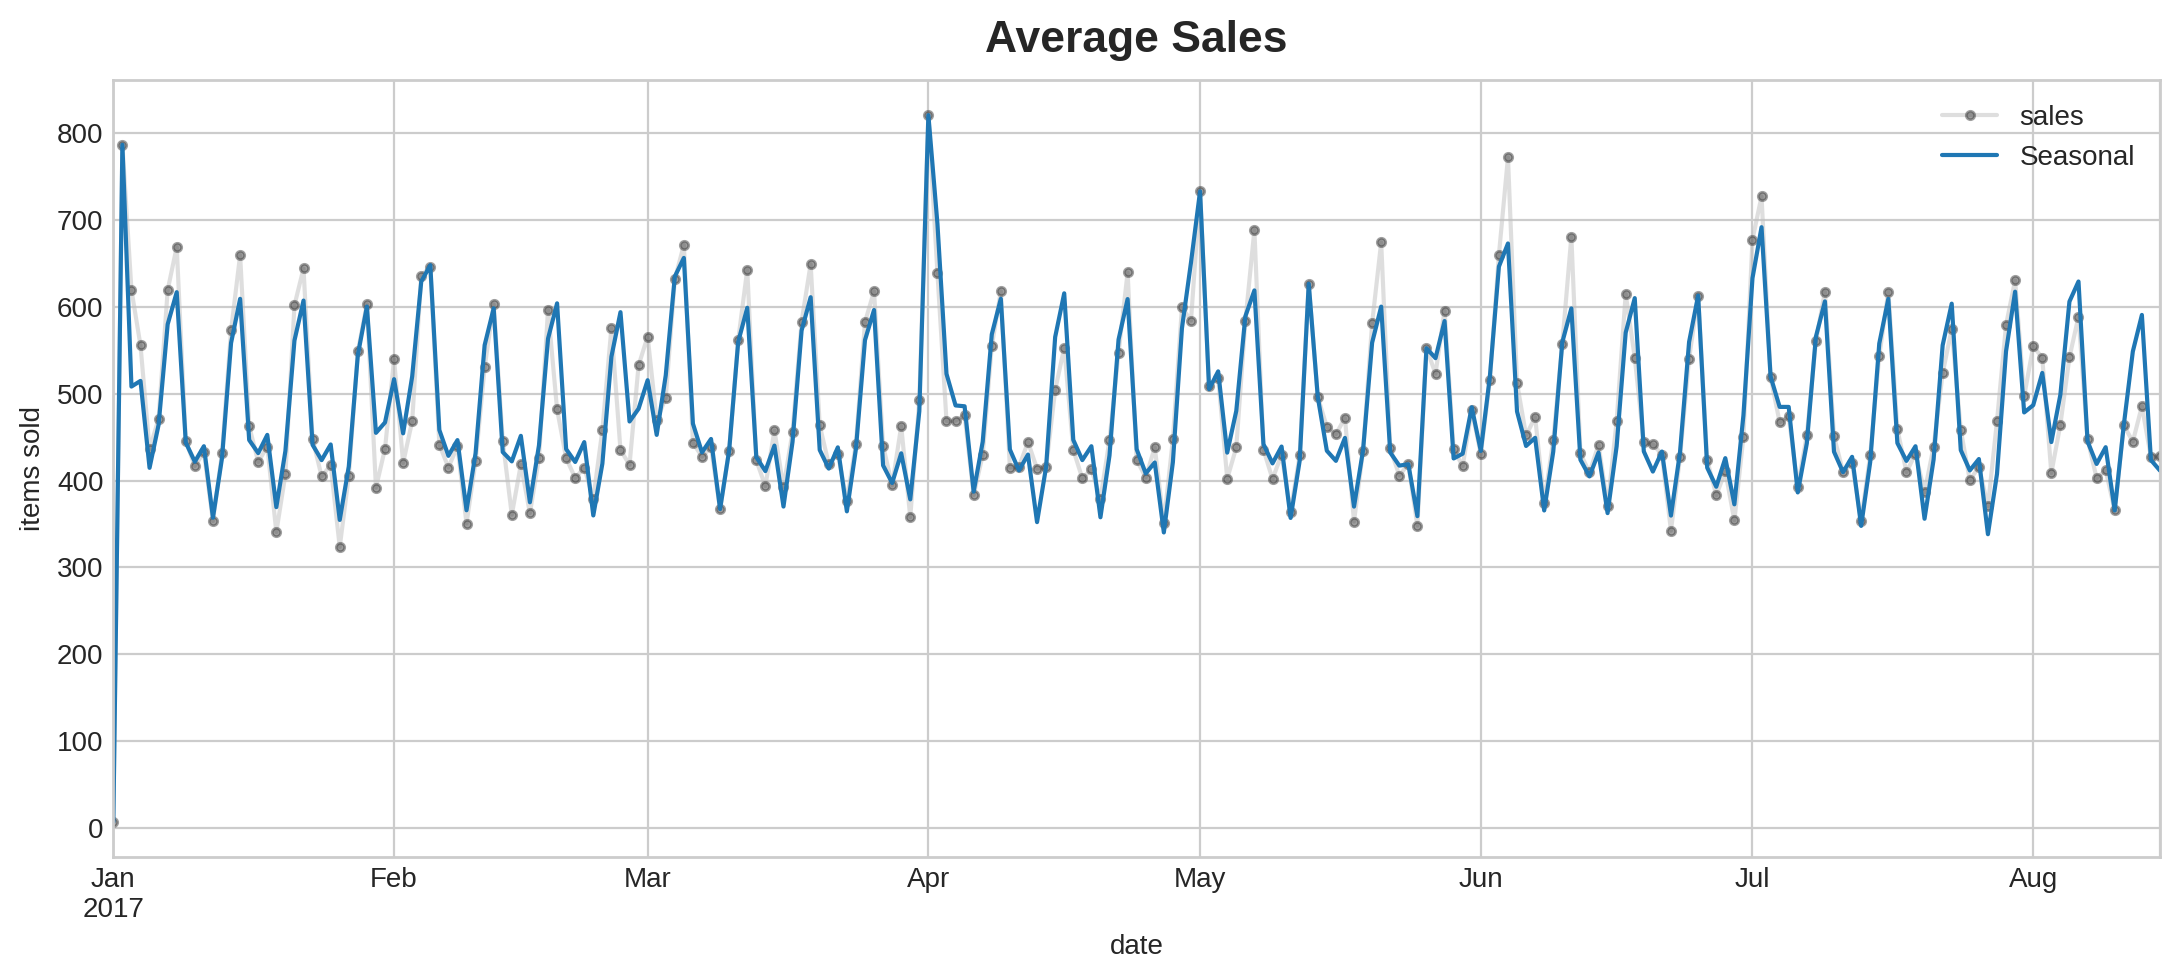

In [29]:
model = LinearRegression().fit(X2, y)

y_pred = pd.Series(
    model.predict(X2),
    index=X2.index,
    name='Fitted',
)

ax = y.plot(**plot_params, alpha=0.5, title='Average Sales', ylabel='items sold')
ax = y_pred.plot(ax=ax, label='Seasonal')
ax.legend();

Instead of using the average values, we can now use the full dataset to train the model.

In [30]:
y = store_sales.unstack(['store_nbr', 'family']).loc['2017']

# Create training data
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

Visualize some of its predictions.

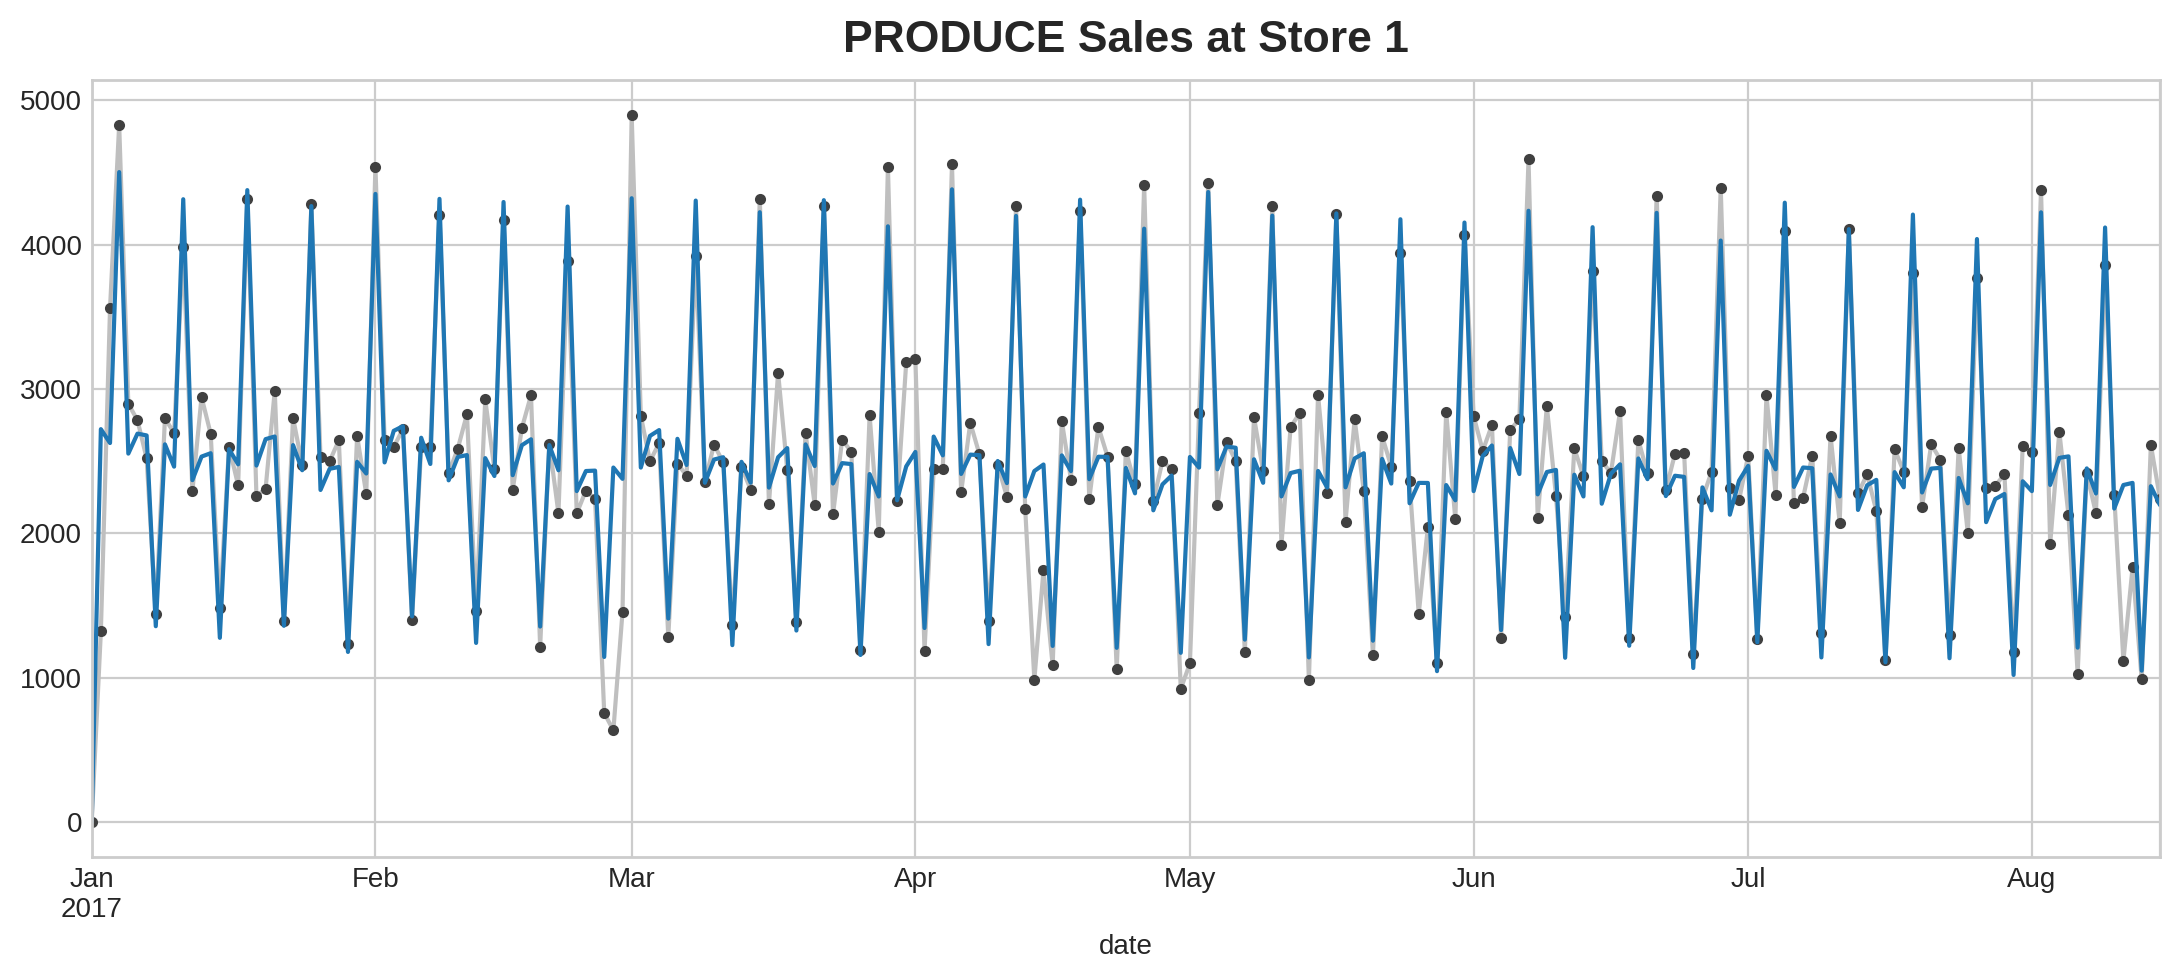

In [31]:
STORE_NBR = '1'
FAMILY = 'PRODUCE'

ax = y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**plot_params)
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

Check for serial dependence (lag dependence) vs time dependence. Also check for cyclic behavior of the time series data. Economies, epidemics, animal populations, volcano eruptions, and similar natural phenomena often display cyclic behavior. What distinguishes cyclic behavior from seasonality is that cycles are not necessarily time dependent, as seasons are. What happens in a cycle is less about the particular date of occurence, and more about what has happened in the recent past. The (at least relative) independence from time means that cyclic behavior can be much more irregular than seasonality.

In [32]:
def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

In [33]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax

In [34]:
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf

In [35]:
store_sales = pd.read_csv(
    path,
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017', ['sales', 'onpromotion']]
)

Not every product family has sales showing cyclic behavior, and neither does the series of average sales. Sales of school and office supplies, however, show patterns of growth and decay not well characterized by trend or seasons. In this question and the next, you'll model cycles in sales of school and office supplies using lag features.

Trend and seasonality will both create serial dependence that shows up in correlograms and lag plots. To isolate any purely cyclic behavior, we'll start by deseasonalizing the series. Use the code in the next cell to deseasonalize Supply Sales. We'll store the result in a variable y_deseason.

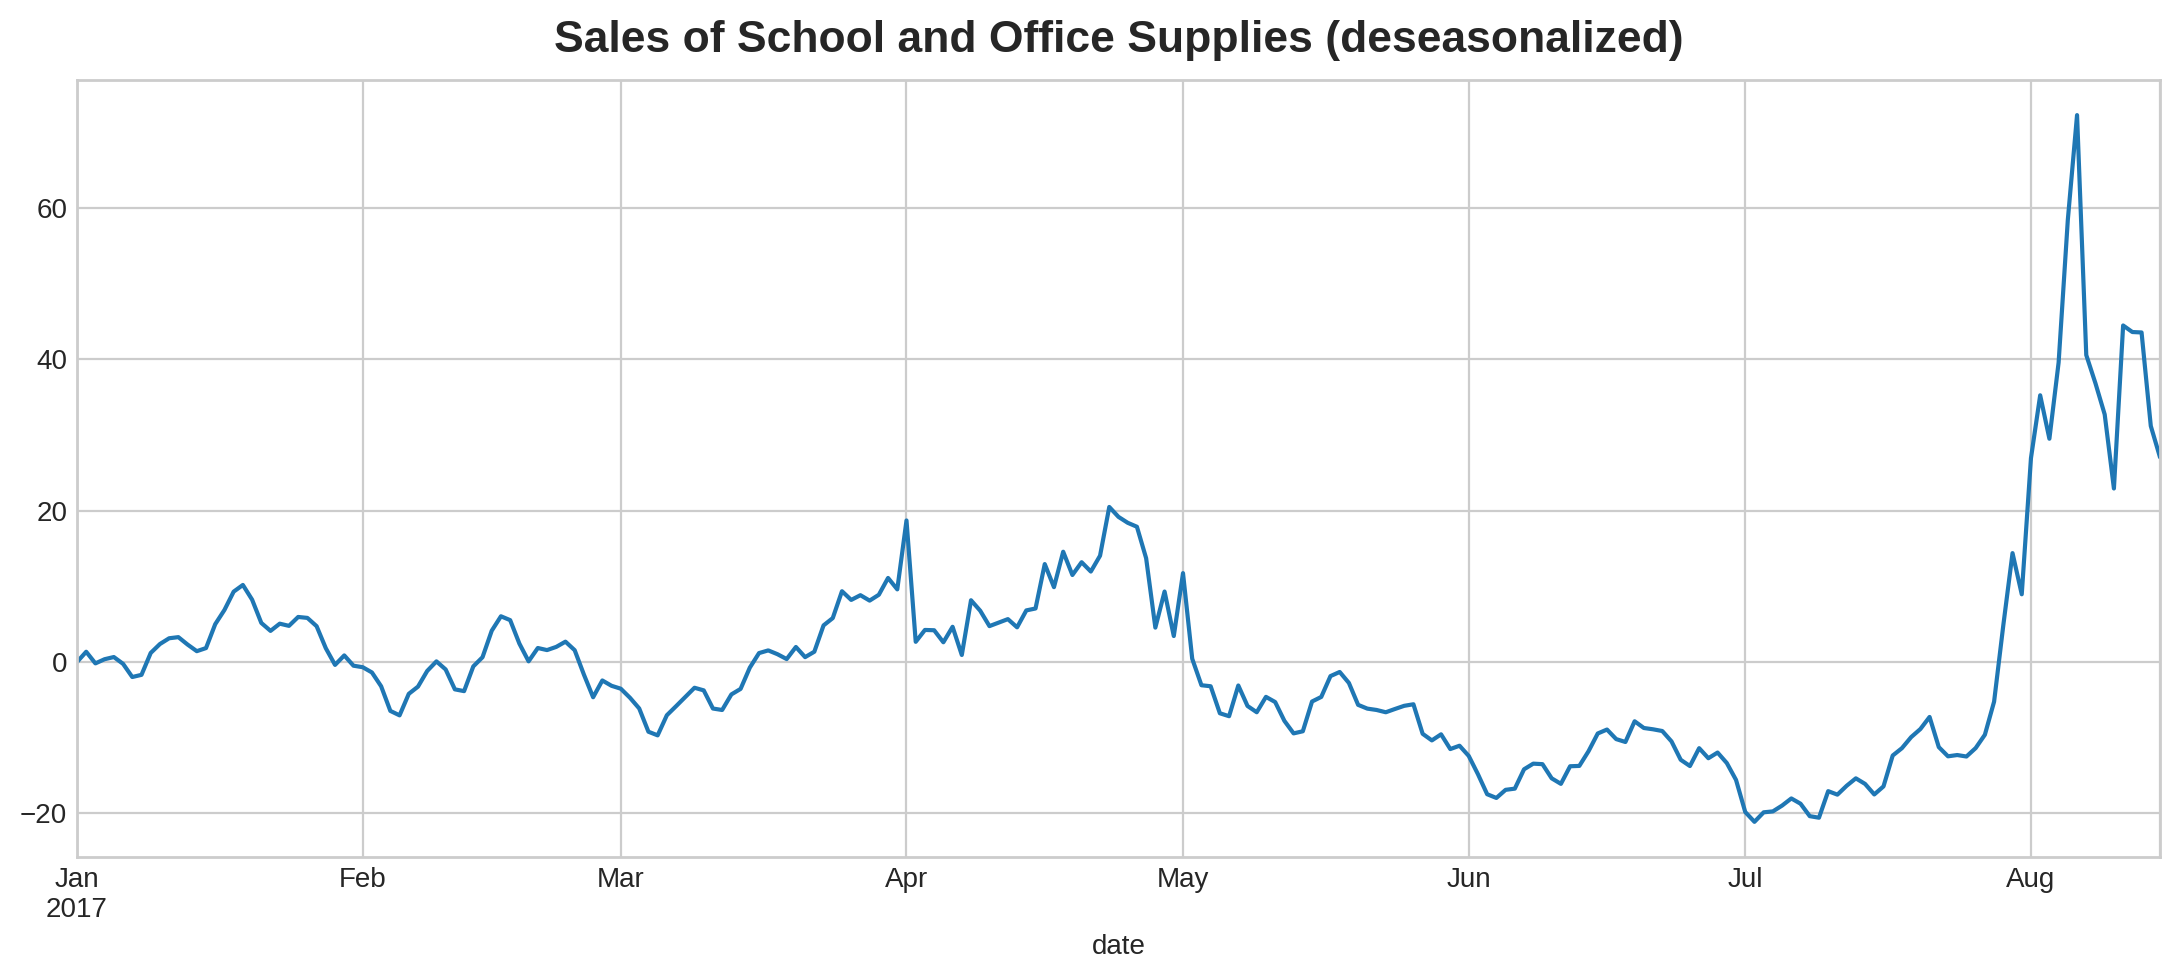

In [36]:
supply_sales = family_sales.loc(axis=1)[:, 'SCHOOL AND OFFICE SUPPLIES']
y = supply_sales.loc[:, 'sales'].squeeze()

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)
X_time = dp.in_sample()
X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X_time, y)
y_deseason = y - model.predict(X_time)
y_deseason.name = 'sales_deseasoned'

ax = y_deseason.plot()
ax.set_title('Sales of School and Office Supplies (deseasonalized)');

Does this deseasonalized series show cyclic patterns? To confirm our intuition, we can try to isolate cyclic behavior using a moving-average plot just like we did with trend. The idea is to choose a window long enough to smooth over short-term seasonality, but short enough to still preserve the cycles.
Create a seven-day moving average from y, the series of supply sales. Use a centered window, but don't set the min_periods argument.

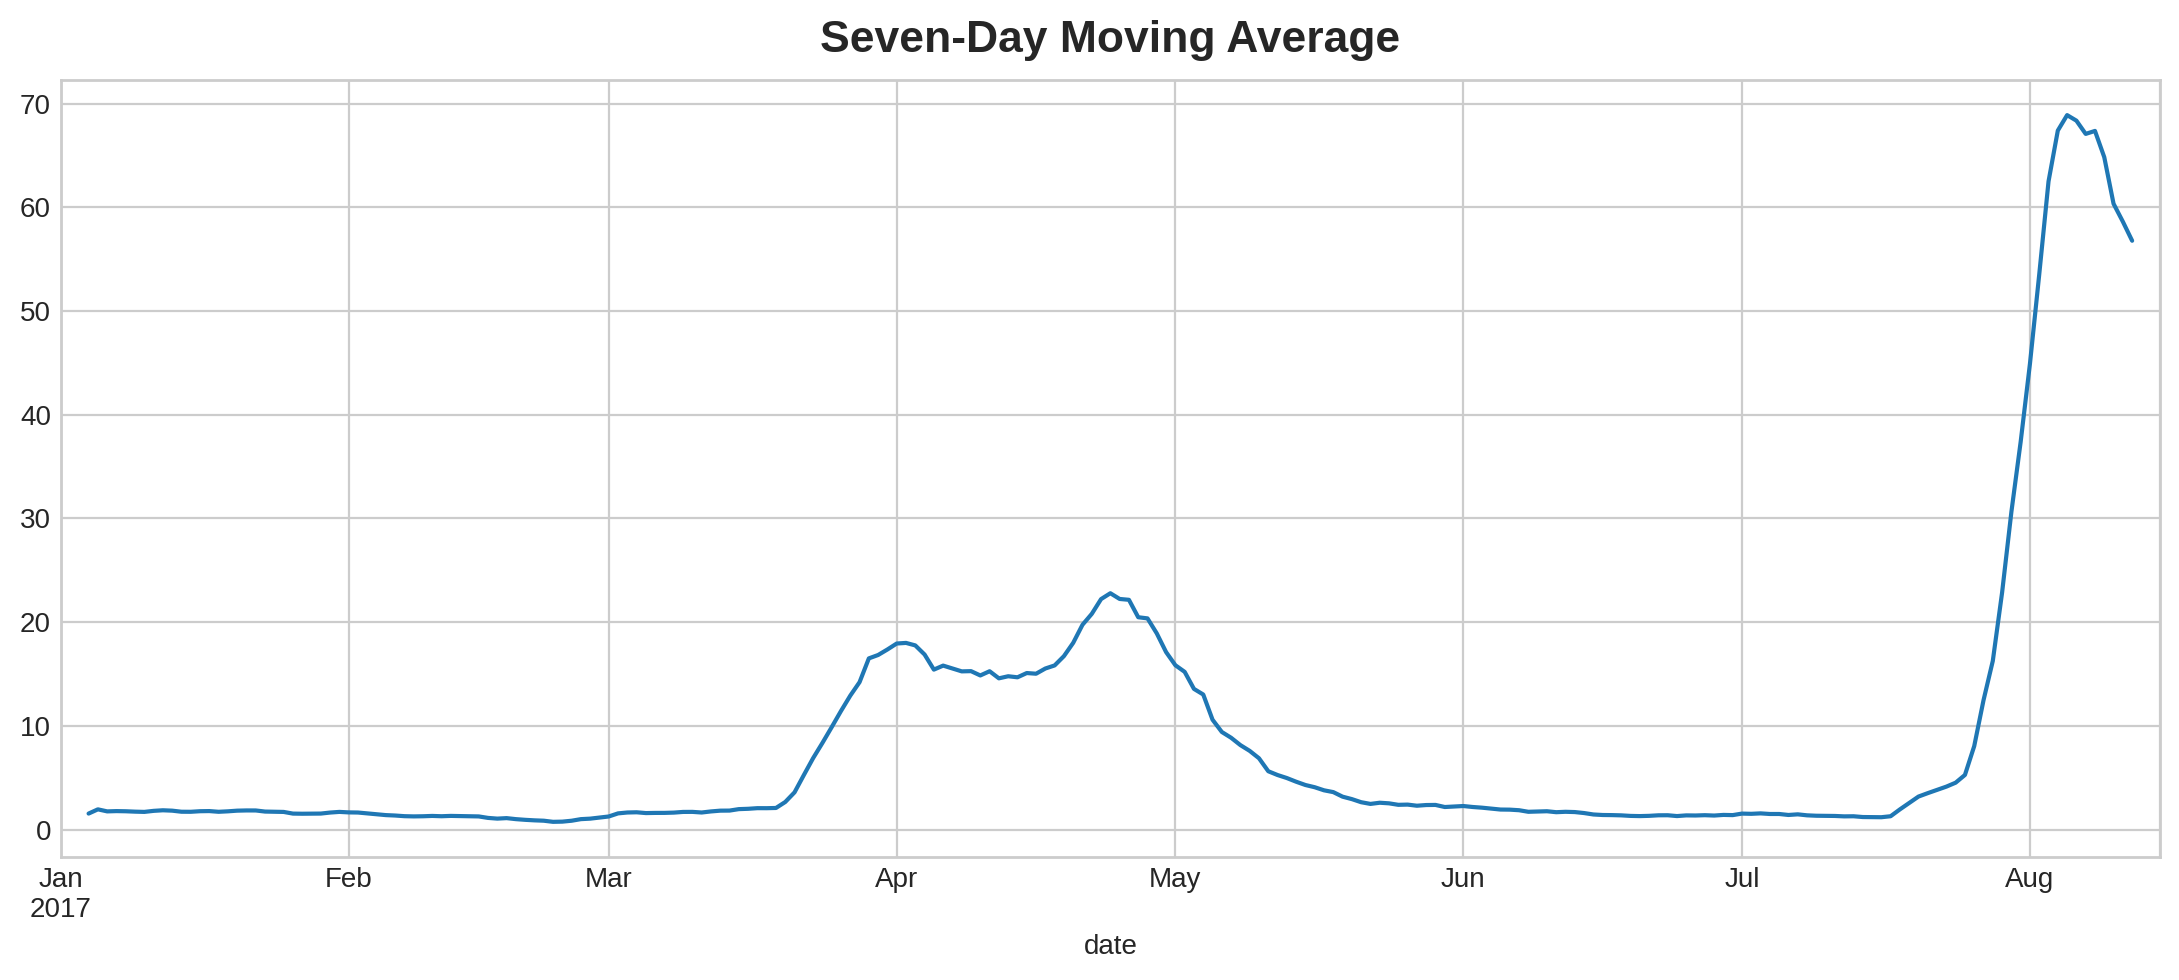

In [37]:
y_ma = y.rolling(
    window=7,
    center=True,
).mean()


# Plot
ax = y_ma.plot()
ax.set_title("Seven-Day Moving Average");


Do you see how the moving average plot resembles the plot of the deseasonalized series? In both, we can see cyclic behavior indicated.

-------------------------------------------------------------------------------

Let's examine our deseasonalized series for serial dependence. Take a look at the partial autocorrelation correlogram and lag plot.

/home/david/anaconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


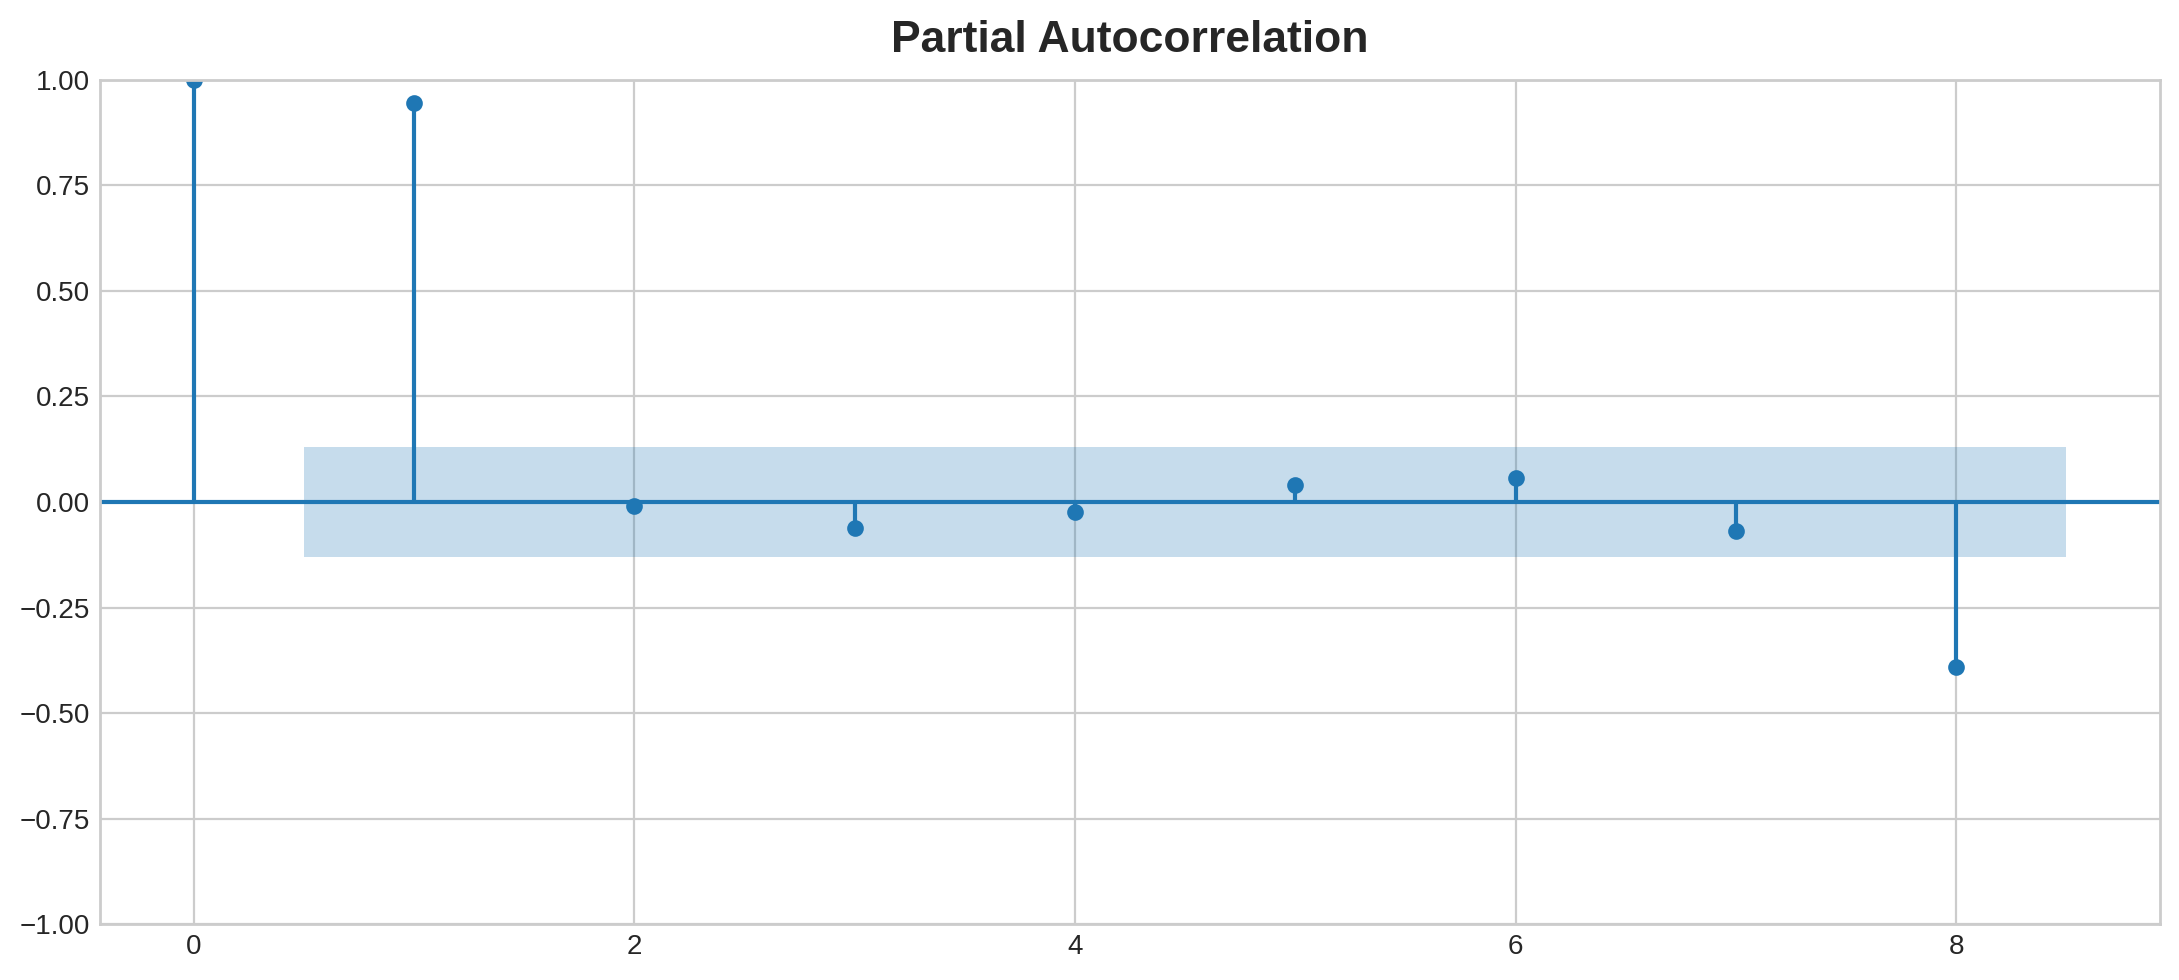

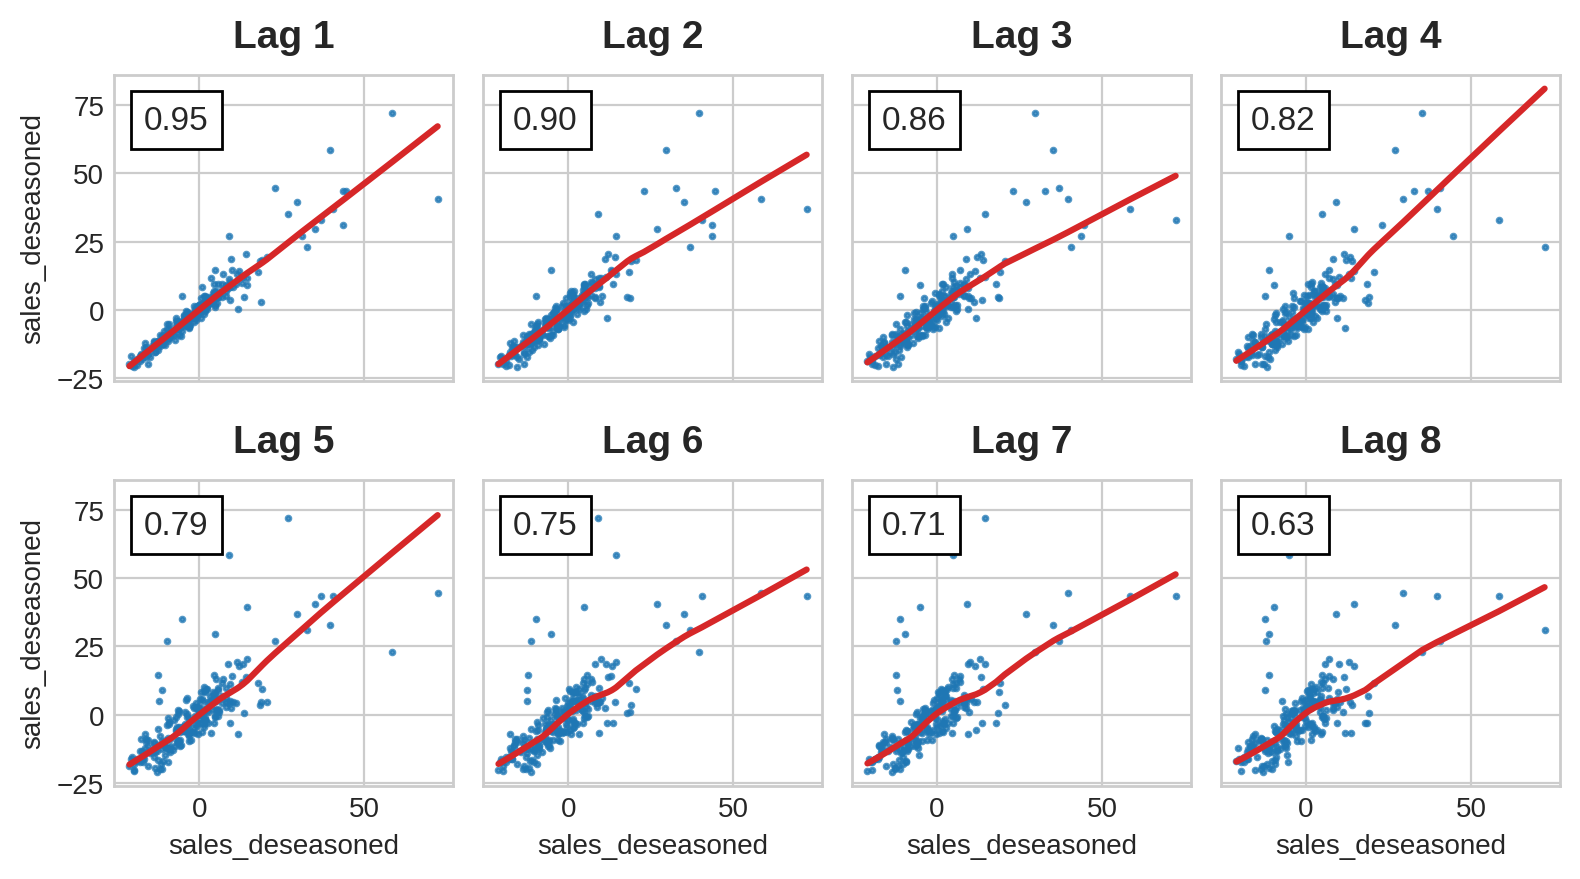

In [38]:
plot_pacf(y_deseason, lags=8);
plot_lags(y_deseason, lags=8, nrows=2);

Are any of the lags significant according to the correlogram? Does the lag plot suggest any relationships that weren't apparent from the correlogram?

The correlogram indicates the first lag is likely to be significant, as well as possibly the eighth lag. The lag plot suggests the effect is mostly linear.

Recall from the tutorial that a leading indicator is a series whose values at one time can be used to predict the target at a future time -- a leading indicator provides "advance notice" of changes in the target.

The competition dataset includes a time series that could potentially be useful as a leading indicator -- the onpromotion series, which contains the number of items on a special promotion that day. Since the company itself decides when to do a promotion, there's no worry about "lookahead leakage"; we could use Tuesday's onpromotion value to forecast sales on Monday, for instance.

Use the next cell to examine leading and lagging values for onpromotion plotted against sales of school and office supplies.

In [39]:
onpromotion = supply_sales.loc[:, 'onpromotion'].squeeze().rename('onpromotion')

# Drop days without promotions
plot_lags(x=onpromotion.loc[onpromotion > 1], y=y_deseason.loc[onpromotion > 1], lags=3, leads=3, nrows=1);

AttributeError: Figure.set() got an unexpected keyword argument 'leads'

Does it appear that either leading or lagging values of onpromotion could be useful as a feature?

The lag plot indicates that both leading and lagged values of onpromotion are correlated with supply sales. This suggests that both kinds of values could be useful as features. There may be some non-linear effects as well.

# Create time series features

In [40]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


In [41]:
# TODO
def make_leads(ts, leads):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, leads + 1)
        },
        axis=1)

In [42]:
X_lags = make_lags(y_deseason, lags=1)

X_promo = pd.concat([
    make_lags(onpromotion, lags=1),
    onpromotion,
    make_leads(onpromotion, leads=1),
], axis=1)

X = pd.concat([X_time, X_lags, X_promo], axis=1).dropna()
y, X = y.align(X, join='inner')

Training RMSLE: 0.23893
Validation RMSLE: 0.34245


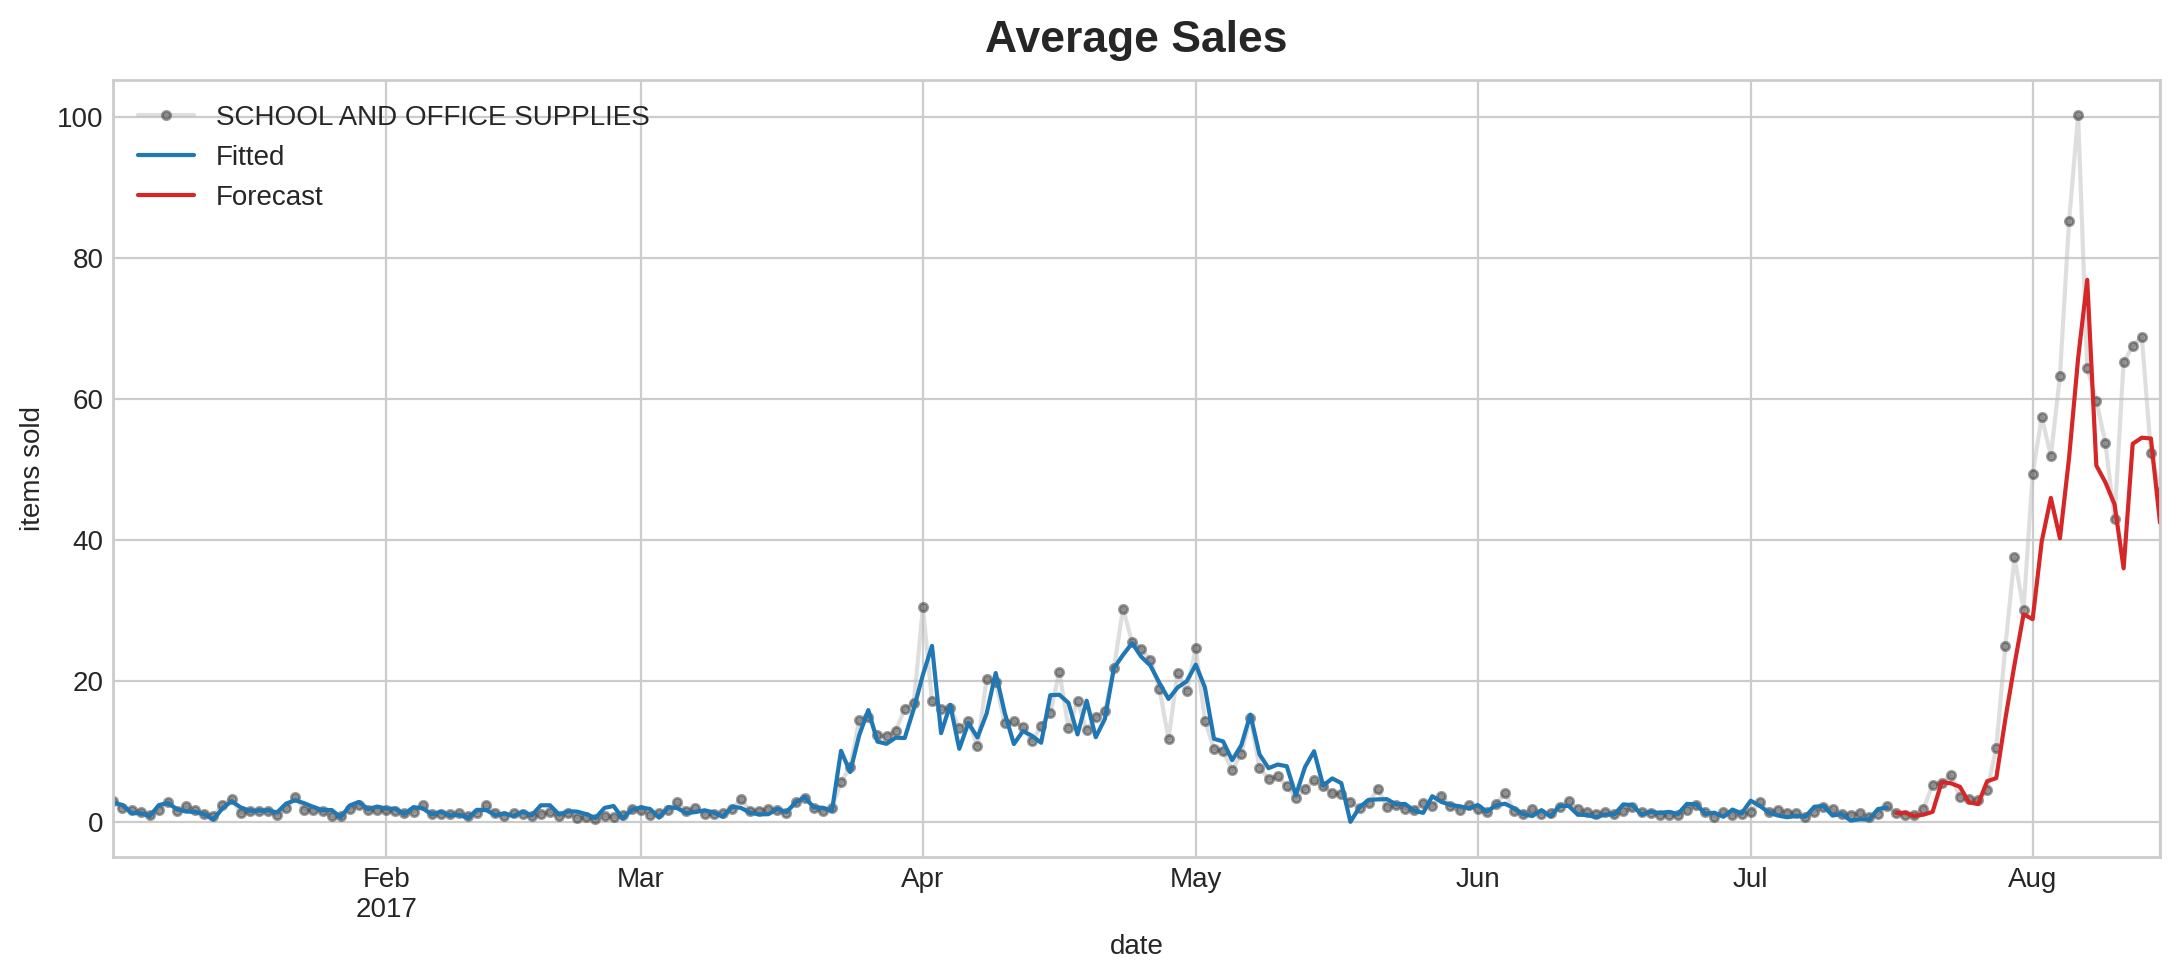

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=30, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fit.plot(ax=ax, label="Fitted", color='C0')
ax = y_pred.plot(ax=ax, label="Forecast", color='C3')
ax.legend();

series = trend + seasons + cycles + error

We could imagine learning the components of a time series as an iterative process: first learn the trend and subtract it out from the series, then learn the seasonality from the detrended residuals and subtract the seasons out, then learn the cycles and subtract the cycles out, and finally only the unpredictable error remains.

# 1. Train and predict with first model
model_1.fit(X_train_1, y_train)
y_pred_1 = model_1.predict(X_train)

# 2. Train and predict with second model on residuals
model_2.fit(X_train_2, y_train - y_pred_1)
y_pred_2 = model_2.predict(X_train_2)

# 3. Add to get overall predictions
y_pred = y_pred_1 + y_pred_2

While it's possible to use more than two models, in practice it doesn't seem to be especially helpful. In fact, the most common strategy for constructing hybrids is the one we've just described: a simple (usually linear) learning algorithm followed by a complex, non-linear learner like GBDTs or a deep neural net, the simple model typically designed as a "helper" for the powerful algorithm that follows.

There are generally two ways a regression algorithm can make predictions: either by transforming the features or by transforming the target. Feature-transforming algorithms learn some mathematical function that takes features as an input and then combines and transforms them to produce an output that matches the target values in the training set. Linear regression and neural nets are of this kind.

Target-transforming algorithms use the features to group the target values in the training set and make predictions by averaging values in a group; a set of feature just indicates which group to average. Decision trees and nearest neighbors are of this kind.

The important thing is this: feature transformers generally can extrapolate target values beyond the training set given appropriate features as inputs, but the predictions of target transformers will always be bound within the range of the training set. If the time dummy continues counting time steps, linear regression continues drawing the trend line. Given the same time dummy, a decision tree will predict the trend indicated by the last step of the training data into the future forever. Decision trees cannot extrapolate trends. Random forests and gradient boosted decision trees (like XGBoost) are ensembles of decision trees, so they also cannot extrapolate trends.

This difference is what motivates the hybrid design in this lesson: use linear regression to extrapolate the trend, transform the target to remove the trend, and apply XGBoost to the detrended residuals. To hybridize a neural net (a feature transformer), you could instead include the predictions of another model as a feature, which the neural net would then include as part of its own predictions. The method of fitting to residuals is actually the same method the gradient boosting algorithm uses, so we will call these boosted hybrids; the method of using predictions as features is known as "stacking", so we will call these stacked hybrids.

In [46]:
store_sales = pd.read_csv(
    path,
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

In the next two questions, you'll create a boosted hybrid for the Store Sales dataset by implementing a new Python class. Run this cell to create the initial class definition. You'll add fit and predict methods to give it a scikit-learn like interface.

In [47]:
# You'll add fit and predict methods to this minimal class
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

# 1) Define fit method for boosted hybrid

In [48]:
def fit(self, X_1, X_2, y):
    # YOUR CODE HERE: fit self.model_1
    self.model_1.fit(X_1, y)

    y_fit = pd.DataFrame(
        # YOUR CODE HERE: make predictions with self.model_1
        self.model_1.predict(X_1),
        index=X_1.index, columns=y.columns,
    )

    # YOUR CODE HERE: compute residuals
    y_resid = y - y_fit
    y_resid = y_resid.stack().squeeze() # wide to long

    # YOUR CODE HERE: fit self.model_2 on residuals
    self.model_2.fit(X_2, y_resid)

    # Save column names for predict method
    self.y_columns = y.columns
    # Save data for question checking
    self.y_fit = y_fit
    self.y_resid = y_resid


# Add method to class
BoostedHybrid.fit = fit


# 2) Define predict method for boosted hybrid


In [50]:
def predict(self, X_1, X_2):
    y_pred = pd.DataFrame(
        # YOUR CODE HERE: predict with self.model_1
        self.model_1.predict(X_1),
        index=X_1.index, columns=self.y_columns,
    )
    y_pred = y_pred.stack().squeeze()  # wide to long

    # YOUR CODE HERE: add self.model_2 predictions to y_pred
    y_pred += self.model_2.predict(X_2)
    
    return y_pred.unstack()  # long to wide


# Add method to class
BoostedHybrid.predict = predict


In [51]:
# Target series
y = family_sales.loc[:, 'sales']


# X_1: Features for Linear Regression
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()


# X_2: Features for XGBoost
X_2 = family_sales.drop('sales', axis=1).stack()  # onpromotion feature

# Label encoding for 'family'
le = LabelEncoder()  # from sklearn.preprocessing
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])

# Label encoding for seasonality
X_2["day"] = X_2.index.day  # values are day of the month

# 3) Train boosted hybrid

In [52]:
# YOUR CODE HERE: Create LinearRegression + XGBRegressor hybrid with BoostedHybrid
model = BoostedHybrid(LinearRegression(), XGBRegressor())

# YOUR CODE HERE: Fit and predict
model.fit(X_1, X_2, y)
y_pred = model.predict(X_1, X_2)

y_pred = y_pred.clip(0.0)

Depending on your problem, you might want to use other hybrid combinations than the linear regression + XGBoost hybrid you've created in the previous questions. Run the next cell to try other algorithms from scikit-learn.

In [53]:
# Model 1 (trend)
from sklearn.linear_model import ElasticNet, Lasso, Ridge

# Model 2
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Boosted Hybrid

# YOUR CODE HERE: Try different combinations of the algorithms above
model = BoostedHybrid(
    model_1=Ridge(),
    model_2=KNeighborsRegressor(),
)

Use the code in this cell to see the predictions your hybrid makes.

/tmp/ipykernel_15700/2926216328.py:16: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  _ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
/tmp/ipykernel_15700/2926216328.py:17: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  _ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)


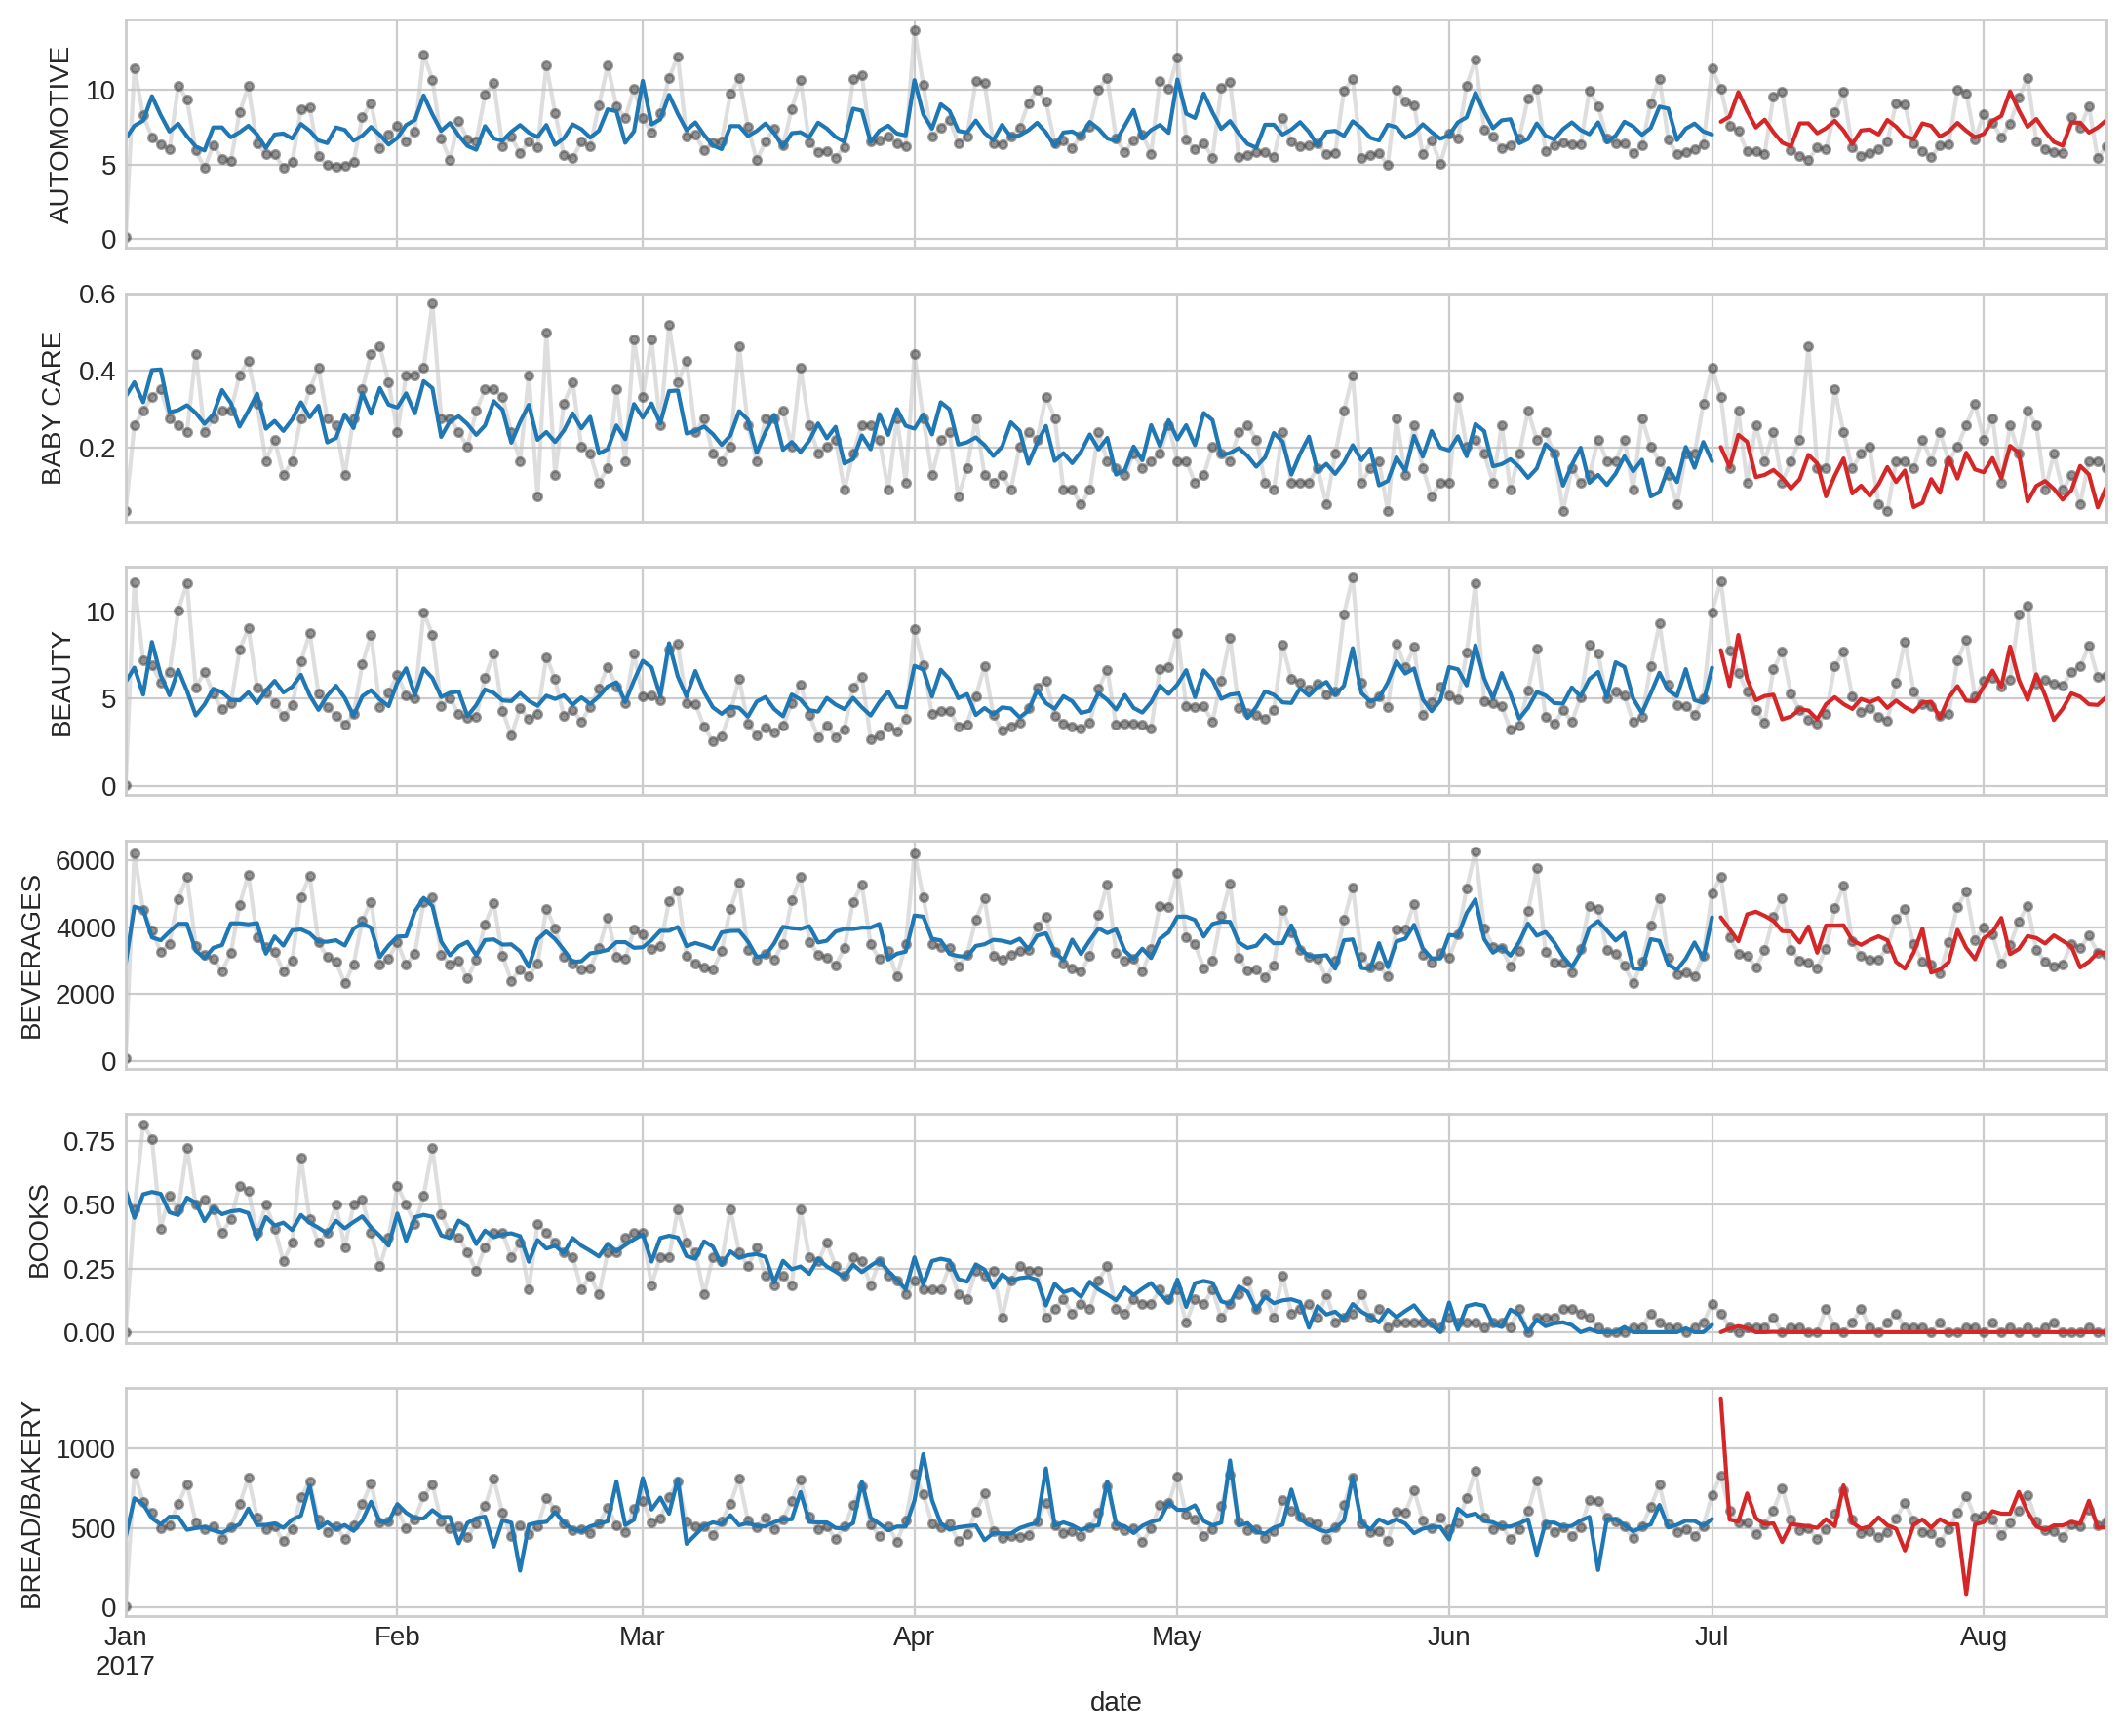

In [54]:
y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[: "2017-07-01"], X_1["2017-07-02" :]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

# Some of the algorithms above do best with certain kinds of
# preprocessing on the features (like standardization), but this is
# just a demo.
model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(11, 9), **plot_params, alpha=0.5,
)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)